In [1]:
from utils import (ConstructDataset,Unet_Discriminator, Unet_Discriminator_V2, Unet_Generator_V2, unet_d_criterion_without_cutmix_v2)
import random
from torchvision import transforms
import torchvision.transforms as transforms
import torch
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

<strong> Building the dataset </strong>

In [2]:
# Building the dataset

image_dir = '../../data/pixel_art/images/images/'

transform = transforms.Compose([
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



images = ConstructDataset(image_dir, transform)

<strong> Sampling an image from the dataset </strong>

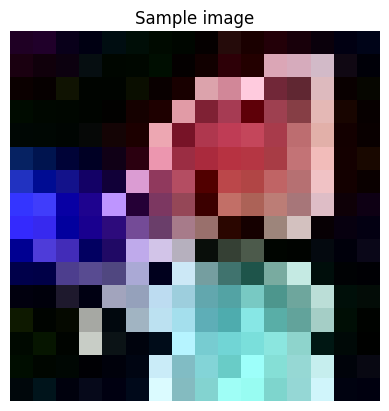

In [3]:
# Plotting an example from  the dataset
n = len(images)
integer = random.randint(0,n)
image = images[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample image')
plt.show()


<strong> Building the dataloader </strong>

In [4]:
dataloader = DataLoader(images, batch_size=256)

<strong> Building the models </strong>

In [5]:
latent_dim = 40
channels_out = 3
input_channels = 3
n_classes = 2

D_unet = Unet_Discriminator_V2(input_channels, n_classes)
G_unet = Unet_Generator_V2(latent_dim, channels_out)

<strong> Generating an image before training the generator </strong>

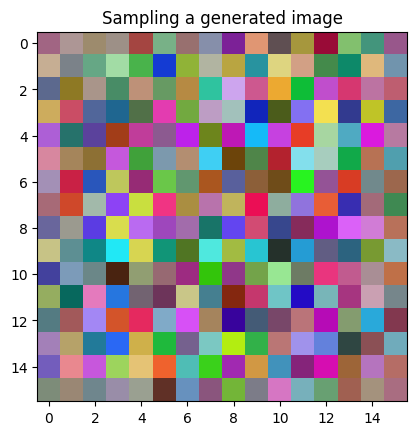

In [6]:
noise_image = D_unet(images[0].unsqueeze(0))[1][0]

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

# Plotting the image 
image_noise = fake_images.detach().numpy().reshape((3,16,16))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

In [7]:
print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


<strong> Training loop</strong>

In [8]:
torch.autograd.set_detect_anomaly(True)

input_channels = 3
n_classes = 2
k = 1 # Steps to train generator
latent_dim = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) 

G_unet = G_unet.to(device)
D_unet = D_unet.to(device)

criterion = unet_d_criterion_without_cutmix_v2

optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.5, 0.999)) 

D_loss, G_loss = [], []

epochs = 1000
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(images)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([images[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_1 = torch.ones(batch_size, 1, device=device)  # Real labels on GPU
        labels_2 = torch.ones(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_1, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = G_unet(noise)
        labels_2.fill_(0)  # Fake labels
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_2, batch_size)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            labels_3 = torch.ones(batch_size, 1, device=device)
            G_unet.zero_grad()
            labels_3.fill_(1)  # Real labels
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_3, batch_size)
            loss_g.backward()
            optimizer_g_unet.step()

    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()
        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)
        # Storing loss values
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())
        # Train mode
        G_unet.train()

            
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0/1000] | Loss D: 347.52593994140625 | Loss G: 191.12461853027344
Epoch 1 duration :   14.403082609176636


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/1000] | Loss D: 181.35011291503906 | Loss G: 244.41505432128906
Epoch 2 duration :   1.6416313648223877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/1000] | Loss D: 448.28863525390625 | Loss G: 302.27471923828125
Epoch 3 duration :   1.2280082702636719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/1000] | Loss D: 335.26654052734375 | Loss G: 221.47506713867188
Epoch 4 duration :   1.2518038749694824


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/1000] | Loss D: 285.535888671875 | Loss G: 226.73223876953125
Epoch 5 duration :   1.086693525314331


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/1000] | Loss D: 243.30682373046875 | Loss G: 265.9576416015625
Epoch 6 duration :   1.0801403522491455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/1000] | Loss D: 230.75894165039062 | Loss G: 301.8208312988281
Epoch 7 duration :   1.074887752532959


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/1000] | Loss D: 231.52598571777344 | Loss G: 321.6112060546875
Epoch 8 duration :   1.1002328395843506


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/1000] | Loss D: 236.4145050048828 | Loss G: 319.97540283203125
Epoch 9 duration :   1.1019861698150635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/1000] | Loss D: 311.03167724609375 | Loss G: 197.30865478515625
Epoch 10 duration :   1.2916710376739502


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/1000] | Loss D: 226.38246154785156 | Loss G: 273.6771545410156
Epoch 11 duration :   1.1199874877929688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/1000] | Loss D: 229.14181518554688 | Loss G: 310.8221435546875
Epoch 12 duration :   1.0454790592193604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/1000] | Loss D: 193.86495971679688 | Loss G: 336.0933837890625
Epoch 13 duration :   1.0452313423156738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/1000] | Loss D: 175.9398193359375 | Loss G: 372.43365478515625
Epoch 14 duration :   1.057708978652954


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/1000] | Loss D: 161.00637817382812 | Loss G: 382.7057189941406
Epoch 15 duration :   1.0382418632507324


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/1000] | Loss D: 165.80712890625 | Loss G: 465.90765380859375
Epoch 16 duration :   1.062201738357544


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/1000] | Loss D: 213.64590454101562 | Loss G: 332.6017761230469
Epoch 17 duration :   1.071753740310669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/1000] | Loss D: 178.2291717529297 | Loss G: 334.79974365234375
Epoch 18 duration :   1.0419790744781494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/1000] | Loss D: 248.58514404296875 | Loss G: 343.5784912109375
Epoch 19 duration :   1.0513145923614502


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/1000] | Loss D: 207.09982299804688 | Loss G: 345.05963134765625
Epoch 20 duration :   1.0057611465454102


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/1000] | Loss D: 282.2625732421875 | Loss G: 274.6788024902344
Epoch 21 duration :   1.0282809734344482


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/1000] | Loss D: 91.66819763183594 | Loss G: 583.3914794921875
Epoch 22 duration :   1.0288071632385254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/1000] | Loss D: 216.71783447265625 | Loss G: 343.18353271484375
Epoch 23 duration :   1.0276439189910889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/1000] | Loss D: 206.68716430664062 | Loss G: 318.5023193359375
Epoch 24 duration :   1.0306859016418457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/1000] | Loss D: 191.44317626953125 | Loss G: 383.0141906738281
Epoch 25 duration :   1.0238018035888672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/1000] | Loss D: 196.46446228027344 | Loss G: 255.57411193847656
Epoch 26 duration :   1.0077450275421143


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/1000] | Loss D: 206.9412078857422 | Loss G: 381.6175537109375
Epoch 27 duration :   1.007523775100708


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/1000] | Loss D: 174.48370361328125 | Loss G: 345.01739501953125
Epoch 28 duration :   1.0127520561218262


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/1000] | Loss D: 220.0896759033203 | Loss G: 252.53607177734375
Epoch 29 duration :   1.0232839584350586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/1000] | Loss D: 159.09518432617188 | Loss G: 416.2237854003906
Epoch 30 duration :   1.0078420639038086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/1000] | Loss D: 162.426513671875 | Loss G: 270.9798278808594
Epoch 31 duration :   1.0056161880493164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/1000] | Loss D: 158.52816772460938 | Loss G: 456.4984130859375
Epoch 32 duration :   0.9964568614959717


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/1000] | Loss D: 124.34745788574219 | Loss G: 428.7675476074219
Epoch 33 duration :   1.0054588317871094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/1000] | Loss D: 108.467041015625 | Loss G: 492.77239990234375
Epoch 34 duration :   1.007197380065918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/1000] | Loss D: 40.54095458984375 | Loss G: 1248.222412109375
Epoch 35 duration :   0.9857895374298096


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/1000] | Loss D: 30.32581329345703 | Loss G: 1174.21533203125
Epoch 36 duration :   1.0082998275756836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/1000] | Loss D: 14.604840278625488 | Loss G: 2640.186767578125
Epoch 37 duration :   1.0163960456848145


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/1000] | Loss D: 17.762022018432617 | Loss G: 1423.0062255859375
Epoch 38 duration :   1.005110263824463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/1000] | Loss D: 419.9716796875 | Loss G: 243.8800506591797
Epoch 39 duration :   1.0022127628326416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/1000] | Loss D: 229.95333862304688 | Loss G: 1049.7763671875
Epoch 40 duration :   1.0092899799346924


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/1000] | Loss D: 5807.2998046875 | Loss G: 876.8075561523438
Epoch 41 duration :   1.0139117240905762


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/1000] | Loss D: 24.272184371948242 | Loss G: 837.9757690429688
Epoch 42 duration :   0.9959683418273926


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/1000] | Loss D: 7.835055351257324 | Loss G: 1302.1552734375
Epoch 43 duration :   1.0082242488861084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/1000] | Loss D: 7.282283782958984 | Loss G: 1771.9842529296875
Epoch 44 duration :   0.9977109432220459


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/1000] | Loss D: 6.149001598358154 | Loss G: 2169.650634765625
Epoch 45 duration :   1.0013341903686523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/1000] | Loss D: 198.4413604736328 | Loss G: 565.8587646484375
Epoch 46 duration :   0.9959566593170166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/1000] | Loss D: 174.45770263671875 | Loss G: 531.5548706054688
Epoch 47 duration :   1.0003881454467773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/1000] | Loss D: 94.72796630859375 | Loss G: 666.86962890625
Epoch 48 duration :   0.9971091747283936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/1000] | Loss D: 111.78714752197266 | Loss G: 626.079833984375
Epoch 49 duration :   1.0150315761566162


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/1000] | Loss D: 62.17898941040039 | Loss G: 1144.53125
Epoch 50 duration :   0.9960269927978516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/1000] | Loss D: 1074.2998046875 | Loss G: 245.0200653076172
Epoch 51 duration :   1.004464864730835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/1000] | Loss D: 125.138916015625 | Loss G: 290.5569152832031
Epoch 52 duration :   0.9935438632965088


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/1000] | Loss D: 175.7896728515625 | Loss G: 342.3581237792969
Epoch 53 duration :   1.0016975402832031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/1000] | Loss D: 119.68496704101562 | Loss G: 453.40313720703125
Epoch 54 duration :   1.011584758758545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/1000] | Loss D: 72.87458801269531 | Loss G: 679.4136962890625
Epoch 55 duration :   1.0039966106414795


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/1000] | Loss D: 69.00312805175781 | Loss G: 519.3960571289062
Epoch 56 duration :   1.003208875656128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/1000] | Loss D: 235.40423583984375 | Loss G: 210.7270965576172
Epoch 57 duration :   1.0223066806793213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/1000] | Loss D: 182.32278442382812 | Loss G: 372.12298583984375
Epoch 58 duration :   1.021824598312378


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/1000] | Loss D: 82.84065246582031 | Loss G: 561.9271850585938
Epoch 59 duration :   1.0125980377197266


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/1000] | Loss D: 42.23326873779297 | Loss G: 1018.2811279296875
Epoch 60 duration :   0.9926977157592773


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/1000] | Loss D: 672.766357421875 | Loss G: 505.8368835449219
Epoch 61 duration :   1.0218915939331055


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/1000] | Loss D: 332.4479675292969 | Loss G: 249.44329833984375
Epoch 62 duration :   1.0158350467681885


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/1000] | Loss D: 300.62603759765625 | Loss G: 217.26417541503906
Epoch 63 duration :   1.0198817253112793


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/1000] | Loss D: 280.60028076171875 | Loss G: 231.47952270507812
Epoch 64 duration :   0.9959800243377686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/1000] | Loss D: 257.74847412109375 | Loss G: 246.5078887939453
Epoch 65 duration :   1.0183265209197998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/1000] | Loss D: 237.50677490234375 | Loss G: 272.5614929199219
Epoch 66 duration :   1.008362054824829


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/1000] | Loss D: 218.90931701660156 | Loss G: 315.9341735839844
Epoch 67 duration :   1.0378930568695068


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/1000] | Loss D: 199.42398071289062 | Loss G: 374.9913330078125
Epoch 68 duration :   1.0523252487182617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/1000] | Loss D: 182.17041015625 | Loss G: 431.9873962402344
Epoch 69 duration :   1.0303845405578613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/1000] | Loss D: 318.53973388671875 | Loss G: 387.5194396972656
Epoch 70 duration :   1.0238306522369385


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/1000] | Loss D: 186.2975616455078 | Loss G: 408.13055419921875
Epoch 71 duration :   1.0093462467193604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/1000] | Loss D: 139.81915283203125 | Loss G: 560.0076904296875
Epoch 72 duration :   1.0281651020050049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/1000] | Loss D: 304.56866455078125 | Loss G: 314.09954833984375
Epoch 73 duration :   0.9972681999206543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/1000] | Loss D: 132.6497802734375 | Loss G: 465.8160400390625
Epoch 74 duration :   1.013357162475586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/1000] | Loss D: 88.287109375 | Loss G: 1426.5684814453125
Epoch 75 duration :   1.0148160457611084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/1000] | Loss D: 172.0635528564453 | Loss G: 420.05499267578125
Epoch 76 duration :   0.9987473487854004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/1000] | Loss D: 76.95668029785156 | Loss G: 1079.1790771484375
Epoch 77 duration :   1.0055866241455078


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/1000] | Loss D: 199.93814086914062 | Loss G: 7.228246212005615
Epoch 78 duration :   1.010765790939331


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/1000] | Loss D: 269.57281494140625 | Loss G: 269.09576416015625
Epoch 79 duration :   1.0186913013458252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/1000] | Loss D: 220.7283935546875 | Loss G: 393.5375671386719
Epoch 80 duration :   1.0105257034301758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/1000] | Loss D: 245.20037841796875 | Loss G: 456.5109558105469
Epoch 81 duration :   1.0149571895599365


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/1000] | Loss D: 123.86451721191406 | Loss G: 885.7669677734375
Epoch 82 duration :   1.004594087600708


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/1000] | Loss D: 55.14952850341797 | Loss G: 1560.5302734375
Epoch 83 duration :   1.0198173522949219


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/1000] | Loss D: 1436.901123046875 | Loss G: 73.01914978027344
Epoch 84 duration :   1.0088880062103271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/1000] | Loss D: 320.6761474609375 | Loss G: 177.31727600097656
Epoch 85 duration :   0.9950222969055176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/1000] | Loss D: 280.6413269042969 | Loss G: 234.52584838867188
Epoch 86 duration :   1.006155014038086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/1000] | Loss D: 133.74868774414062 | Loss G: 351.6343688964844
Epoch 87 duration :   0.9982187747955322


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/1000] | Loss D: 50.706268310546875 | Loss G: 1798.8446044921875
Epoch 88 duration :   1.0055127143859863


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/1000] | Loss D: 430.6245422363281 | Loss G: 0.1325322687625885
Epoch 89 duration :   0.994657039642334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/1000] | Loss D: 289.3841247558594 | Loss G: 374.44769287109375
Epoch 90 duration :   1.007624626159668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/1000] | Loss D: 260.234130859375 | Loss G: 341.9018249511719
Epoch 91 duration :   1.0034117698669434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/1000] | Loss D: 239.34878540039062 | Loss G: 338.7909240722656
Epoch 92 duration :   1.0475540161132812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/1000] | Loss D: 241.5172119140625 | Loss G: 626.9185791015625
Epoch 93 duration :   1.0548367500305176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/1000] | Loss D: 182.01473999023438 | Loss G: 656.3567504882812
Epoch 94 duration :   1.0077834129333496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/1000] | Loss D: 123.48038482666016 | Loss G: 906.5018920898438
Epoch 95 duration :   1.0115785598754883


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/1000] | Loss D: 89.9715576171875 | Loss G: 1194.46435546875
Epoch 96 duration :   1.0204801559448242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/1000] | Loss D: 64.30359649658203 | Loss G: 1407.2049560546875
Epoch 97 duration :   1.0062978267669678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/1000] | Loss D: 286.3155212402344 | Loss G: 1771.01513671875
Epoch 98 duration :   1.0191984176635742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/1000] | Loss D: 321.43243408203125 | Loss G: 171.2032928466797
Epoch 99 duration :   1.0007901191711426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/1000] | Loss D: 202.72998046875 | Loss G: 419.1170959472656
Epoch 100 duration :   1.0143139362335205


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/1000] | Loss D: 100.34184265136719 | Loss G: 1008.6087646484375
Epoch 101 duration :   11.43508505821228


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [101/1000] | Loss D: 43.541168212890625 | Loss G: 1805.6158447265625
Epoch 102 duration :   1.7334458827972412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [102/1000] | Loss D: 742.033447265625 | Loss G: 0.45939818024635315
Epoch 103 duration :   1.177440881729126


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [103/1000] | Loss D: 355.4320068359375 | Loss G: 146.92979431152344
Epoch 104 duration :   1.1906731128692627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [104/1000] | Loss D: 334.23150634765625 | Loss G: 175.7767333984375
Epoch 105 duration :   1.1886370182037354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [105/1000] | Loss D: 323.44775390625 | Loss G: 193.8121795654297
Epoch 106 duration :   1.12788987159729


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [106/1000] | Loss D: 301.10626220703125 | Loss G: 224.40591430664062
Epoch 107 duration :   1.0706121921539307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [107/1000] | Loss D: 261.8642883300781 | Loss G: 206.4041748046875
Epoch 108 duration :   1.0763232707977295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [108/1000] | Loss D: 302.4206237792969 | Loss G: 186.18698120117188
Epoch 109 duration :   1.0655262470245361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [109/1000] | Loss D: 213.9617919921875 | Loss G: 431.0113830566406
Epoch 110 duration :   1.0512046813964844


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [110/1000] | Loss D: 143.7556915283203 | Loss G: 826.55029296875
Epoch 111 duration :   1.082186222076416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [111/1000] | Loss D: 361.865966796875 | Loss G: 179.66453552246094
Epoch 112 duration :   1.0717010498046875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [112/1000] | Loss D: 175.137939453125 | Loss G: 540.5797119140625
Epoch 113 duration :   1.1647613048553467


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [113/1000] | Loss D: 119.35531616210938 | Loss G: 1085.25048828125
Epoch 114 duration :   1.1357979774475098


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [114/1000] | Loss D: 468.1546630859375 | Loss G: 95.15298461914062
Epoch 115 duration :   1.1109473705291748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [115/1000] | Loss D: 346.2685546875 | Loss G: 130.23963928222656
Epoch 116 duration :   1.0804331302642822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [116/1000] | Loss D: 343.39630126953125 | Loss G: 147.66790771484375
Epoch 117 duration :   1.0556762218475342


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [117/1000] | Loss D: 340.89703369140625 | Loss G: 149.4363250732422
Epoch 118 duration :   0.9936685562133789


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [118/1000] | Loss D: 337.5517272949219 | Loss G: 146.33035278320312
Epoch 119 duration :   1.017326831817627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [119/1000] | Loss D: 334.28070068359375 | Loss G: 145.36318969726562
Epoch 120 duration :   1.0094690322875977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [120/1000] | Loss D: 326.99407958984375 | Loss G: 142.37091064453125
Epoch 121 duration :   1.0053987503051758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [121/1000] | Loss D: 317.1605529785156 | Loss G: 140.9227294921875
Epoch 122 duration :   1.0254485607147217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [122/1000] | Loss D: 300.3623046875 | Loss G: 140.18418884277344
Epoch 123 duration :   1.0050761699676514


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [123/1000] | Loss D: 274.8138122558594 | Loss G: 135.28900146484375
Epoch 124 duration :   1.008793830871582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [124/1000] | Loss D: 288.0712585449219 | Loss G: 176.45433044433594
Epoch 125 duration :   1.0176093578338623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [125/1000] | Loss D: 275.455810546875 | Loss G: 132.7293701171875
Epoch 126 duration :   1.000870943069458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [126/1000] | Loss D: 218.66390991210938 | Loss G: 167.00462341308594
Epoch 127 duration :   1.056279182434082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [127/1000] | Loss D: 199.59666442871094 | Loss G: 179.67868041992188
Epoch 128 duration :   1.0144696235656738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [128/1000] | Loss D: 199.71951293945312 | Loss G: 185.20582580566406
Epoch 129 duration :   1.0119974613189697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [129/1000] | Loss D: 179.87539672851562 | Loss G: 182.20040893554688
Epoch 130 duration :   1.009413480758667


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [130/1000] | Loss D: 181.21348571777344 | Loss G: 200.01507568359375
Epoch 131 duration :   1.0227789878845215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [131/1000] | Loss D: 359.56854248046875 | Loss G: 203.70457458496094
Epoch 132 duration :   1.00063157081604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [132/1000] | Loss D: 345.177001953125 | Loss G: 221.54071044921875
Epoch 133 duration :   1.0152466297149658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [133/1000] | Loss D: 301.1156921386719 | Loss G: 488.5755920410156
Epoch 134 duration :   1.0465202331542969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [134/1000] | Loss D: 220.8206787109375 | Loss G: 838.3914794921875
Epoch 135 duration :   1.0255179405212402


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [135/1000] | Loss D: 305.4523620605469 | Loss G: 146.70758056640625
Epoch 136 duration :   1.007131814956665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [136/1000] | Loss D: 263.5022888183594 | Loss G: 212.2247772216797
Epoch 137 duration :   1.0315778255462646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [137/1000] | Loss D: 87.50752258300781 | Loss G: 940.80078125
Epoch 138 duration :   1.059490442276001


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [138/1000] | Loss D: 16799.125 | Loss G: 454.6405334472656
Epoch 139 duration :   1.0241055488586426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [139/1000] | Loss D: 331.73931884765625 | Loss G: 221.37953186035156
Epoch 140 duration :   1.001701831817627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [140/1000] | Loss D: 286.4931335449219 | Loss G: 410.7816467285156
Epoch 141 duration :   1.0224597454071045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [141/1000] | Loss D: 232.03245544433594 | Loss G: 649.8951416015625
Epoch 142 duration :   1.0347445011138916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [142/1000] | Loss D: 196.3914794921875 | Loss G: 890.2039184570312
Epoch 143 duration :   1.0103402137756348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [143/1000] | Loss D: 185.76107788085938 | Loss G: 887.1113891601562
Epoch 144 duration :   1.0198111534118652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [144/1000] | Loss D: 159.25144958496094 | Loss G: 883.612060546875
Epoch 145 duration :   1.0318849086761475


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [145/1000] | Loss D: 408.6690368652344 | Loss G: 101.25580596923828
Epoch 146 duration :   1.0085492134094238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [146/1000] | Loss D: 307.9842224121094 | Loss G: 142.22744750976562
Epoch 147 duration :   1.021111011505127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [147/1000] | Loss D: 265.6292419433594 | Loss G: 151.20994567871094
Epoch 148 duration :   1.0540332794189453


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [148/1000] | Loss D: 235.10980224609375 | Loss G: 162.09942626953125
Epoch 149 duration :   1.0064496994018555


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [149/1000] | Loss D: 215.8609619140625 | Loss G: 164.38514709472656
Epoch 150 duration :   1.013953447341919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [150/1000] | Loss D: 203.79505920410156 | Loss G: 173.45335388183594
Epoch 151 duration :   1.0198898315429688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [151/1000] | Loss D: 201.21963500976562 | Loss G: 179.89373779296875
Epoch 152 duration :   1.0222461223602295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [152/1000] | Loss D: 185.9080047607422 | Loss G: 174.59429931640625
Epoch 153 duration :   1.014571189880371


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [153/1000] | Loss D: 187.0974884033203 | Loss G: 188.14512634277344
Epoch 154 duration :   1.0003454685211182


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [154/1000] | Loss D: 177.3710479736328 | Loss G: 191.70016479492188
Epoch 155 duration :   1.013439655303955


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [155/1000] | Loss D: 170.31765747070312 | Loss G: 198.0613250732422
Epoch 156 duration :   0.9952738285064697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [156/1000] | Loss D: 162.4450225830078 | Loss G: 202.07875061035156
Epoch 157 duration :   1.0079970359802246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [157/1000] | Loss D: 209.34591674804688 | Loss G: 202.88970947265625
Epoch 158 duration :   0.9974908828735352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [158/1000] | Loss D: 355.977294921875 | Loss G: 199.53941345214844
Epoch 159 duration :   1.007009506225586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [159/1000] | Loss D: 330.51947021484375 | Loss G: 175.42515563964844
Epoch 160 duration :   1.0291523933410645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [160/1000] | Loss D: 314.2598571777344 | Loss G: 157.16224670410156
Epoch 161 duration :   1.0316524505615234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [161/1000] | Loss D: 299.40087890625 | Loss G: 163.31346130371094
Epoch 162 duration :   1.014700174331665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [162/1000] | Loss D: 272.2425537109375 | Loss G: 169.0257568359375
Epoch 163 duration :   1.0397863388061523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [163/1000] | Loss D: 230.73281860351562 | Loss G: 194.56175231933594
Epoch 164 duration :   0.9990816116333008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [164/1000] | Loss D: 114.62833404541016 | Loss G: 773.7565307617188
Epoch 165 duration :   1.0128908157348633


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [165/1000] | Loss D: 453.9223937988281 | Loss G: 295.9361572265625
Epoch 166 duration :   1.0121378898620605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [166/1000] | Loss D: 340.83282470703125 | Loss G: 195.2733917236328
Epoch 167 duration :   1.0176877975463867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [167/1000] | Loss D: 332.22979736328125 | Loss G: 205.69407653808594
Epoch 168 duration :   0.99627685546875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [168/1000] | Loss D: 323.3274841308594 | Loss G: 203.74632263183594
Epoch 169 duration :   1.016324520111084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [169/1000] | Loss D: 311.1660461425781 | Loss G: 211.90420532226562
Epoch 170 duration :   1.0038588047027588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [170/1000] | Loss D: 302.37261962890625 | Loss G: 225.49786376953125
Epoch 171 duration :   1.0051910877227783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [171/1000] | Loss D: 296.04034423828125 | Loss G: 238.84109497070312
Epoch 172 duration :   1.009756088256836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [172/1000] | Loss D: 288.1965637207031 | Loss G: 253.1449737548828
Epoch 173 duration :   1.0260651111602783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [173/1000] | Loss D: 276.13031005859375 | Loss G: 218.5270538330078
Epoch 174 duration :   1.0194318294525146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [174/1000] | Loss D: 279.1841125488281 | Loss G: 240.20814514160156
Epoch 175 duration :   1.0270121097564697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [175/1000] | Loss D: 270.0547180175781 | Loss G: 498.1347351074219
Epoch 176 duration :   1.01344633102417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [176/1000] | Loss D: 323.33148193359375 | Loss G: 154.1973419189453
Epoch 177 duration :   0.9962494373321533


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [177/1000] | Loss D: 241.0287322998047 | Loss G: 207.8223876953125
Epoch 178 duration :   1.0252320766448975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [178/1000] | Loss D: 446.89276123046875 | Loss G: 269.92230224609375
Epoch 179 duration :   1.003359317779541


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [179/1000] | Loss D: 347.3421630859375 | Loss G: 226.6632080078125
Epoch 180 duration :   0.9948601722717285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [180/1000] | Loss D: 215.57864379882812 | Loss G: 256.4673156738281
Epoch 181 duration :   1.0043516159057617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [181/1000] | Loss D: 148.524658203125 | Loss G: 387.9464416503906
Epoch 182 duration :   0.9904131889343262


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [182/1000] | Loss D: 65.85493469238281 | Loss G: 1077.9798583984375
Epoch 183 duration :   1.0175774097442627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [183/1000] | Loss D: 482.00274658203125 | Loss G: 71.45555877685547
Epoch 184 duration :   0.9928045272827148


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [184/1000] | Loss D: 297.50018310546875 | Loss G: 136.27406311035156
Epoch 185 duration :   1.0051498413085938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [185/1000] | Loss D: 297.82403564453125 | Loss G: 182.49539184570312
Epoch 186 duration :   0.998093843460083


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [186/1000] | Loss D: 230.4735565185547 | Loss G: 387.5642395019531
Epoch 187 duration :   0.9963493347167969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [187/1000] | Loss D: 382.20556640625 | Loss G: 282.68511962890625
Epoch 188 duration :   1.0087556838989258


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [188/1000] | Loss D: 218.46307373046875 | Loss G: 407.3284912109375
Epoch 189 duration :   1.0050804615020752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [189/1000] | Loss D: 333.9712829589844 | Loss G: 84.72640228271484
Epoch 190 duration :   1.000133991241455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [190/1000] | Loss D: 343.9801025390625 | Loss G: 161.50909423828125
Epoch 191 duration :   1.0045502185821533


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [191/1000] | Loss D: 257.5983581542969 | Loss G: 329.11175537109375
Epoch 192 duration :   1.0181076526641846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [192/1000] | Loss D: 161.2215118408203 | Loss G: 647.8618774414062
Epoch 193 duration :   1.014650821685791


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [193/1000] | Loss D: 123.78124237060547 | Loss G: 1279.07568359375
Epoch 194 duration :   1.000412940979004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [194/1000] | Loss D: 557.232666015625 | Loss G: 48.27518844604492
Epoch 195 duration :   1.0041882991790771


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [195/1000] | Loss D: 340.7443542480469 | Loss G: 164.70590209960938
Epoch 196 duration :   0.9907481670379639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [196/1000] | Loss D: 293.75347900390625 | Loss G: 176.30787658691406
Epoch 197 duration :   0.9830193519592285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [197/1000] | Loss D: 248.66183471679688 | Loss G: 168.39669799804688
Epoch 198 duration :   1.0017457008361816


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [198/1000] | Loss D: 253.7849578857422 | Loss G: 164.30686950683594
Epoch 199 duration :   1.0054066181182861


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [199/1000] | Loss D: 191.88088989257812 | Loss G: 193.48477172851562
Epoch 200 duration :   0.9969007968902588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [200/1000] | Loss D: 183.52383422851562 | Loss G: 197.65870666503906
Epoch 201 duration :   10.02336835861206


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [201/1000] | Loss D: 348.63031005859375 | Loss G: 122.6631088256836
Epoch 202 duration :   1.4787006378173828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [202/1000] | Loss D: 224.08181762695312 | Loss G: 174.69676208496094
Epoch 203 duration :   1.015099048614502


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [203/1000] | Loss D: 193.38134765625 | Loss G: 192.88519287109375
Epoch 204 duration :   1.027897596359253


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [204/1000] | Loss D: 157.13136291503906 | Loss G: 210.11508178710938
Epoch 205 duration :   1.0189952850341797


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [205/1000] | Loss D: 156.6473388671875 | Loss G: 203.12680053710938
Epoch 206 duration :   1.0176506042480469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [206/1000] | Loss D: 145.58506774902344 | Loss G: 219.92959594726562
Epoch 207 duration :   1.0178401470184326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [207/1000] | Loss D: 300.3493347167969 | Loss G: 170.22552490234375
Epoch 208 duration :   1.0136566162109375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [208/1000] | Loss D: 186.9674072265625 | Loss G: 187.1090545654297
Epoch 209 duration :   1.030625581741333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [209/1000] | Loss D: 170.29080200195312 | Loss G: 199.63002014160156
Epoch 210 duration :   1.0272483825683594


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [210/1000] | Loss D: 158.0049285888672 | Loss G: 207.69578552246094
Epoch 211 duration :   1.016770839691162


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [211/1000] | Loss D: 191.4295196533203 | Loss G: 221.36854553222656
Epoch 212 duration :   1.0221521854400635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [212/1000] | Loss D: 356.8440856933594 | Loss G: 240.08848571777344
Epoch 213 duration :   1.0140917301177979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [213/1000] | Loss D: 329.79278564453125 | Loss G: 222.17239379882812
Epoch 214 duration :   1.0354604721069336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [214/1000] | Loss D: 315.30059814453125 | Loss G: 211.77854919433594
Epoch 215 duration :   0.9970171451568604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [215/1000] | Loss D: 304.154052734375 | Loss G: 224.58676147460938
Epoch 216 duration :   1.013850450515747


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [216/1000] | Loss D: 281.20880126953125 | Loss G: 206.38853454589844
Epoch 217 duration :   1.0254549980163574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [217/1000] | Loss D: 248.16900634765625 | Loss G: 157.85079956054688
Epoch 218 duration :   1.0076522827148438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [218/1000] | Loss D: 260.40692138671875 | Loss G: 286.8902893066406
Epoch 219 duration :   0.9948093891143799


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [219/1000] | Loss D: 193.54110717773438 | Loss G: 320.0449523925781
Epoch 220 duration :   1.0113215446472168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [220/1000] | Loss D: 136.81173706054688 | Loss G: 369.9069519042969
Epoch 221 duration :   0.9975428581237793


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [221/1000] | Loss D: 602.996337890625 | Loss G: 406.47174072265625
Epoch 222 duration :   1.0087451934814453


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [222/1000] | Loss D: 328.9505920410156 | Loss G: 226.845703125
Epoch 223 duration :   0.9956259727478027


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [223/1000] | Loss D: 323.90472412109375 | Loss G: 239.7598876953125
Epoch 224 duration :   1.007338047027588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [224/1000] | Loss D: 312.7037048339844 | Loss G: 216.94187927246094
Epoch 225 duration :   1.0148508548736572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [225/1000] | Loss D: 304.5655517578125 | Loss G: 223.41702270507812
Epoch 226 duration :   1.0230329036712646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [226/1000] | Loss D: 293.0146484375 | Loss G: 236.89566040039062
Epoch 227 duration :   1.0194721221923828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [227/1000] | Loss D: 244.80450439453125 | Loss G: 317.985107421875
Epoch 228 duration :   1.015496015548706


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [228/1000] | Loss D: 328.2833251953125 | Loss G: 233.76290893554688
Epoch 229 duration :   0.9983758926391602


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [229/1000] | Loss D: 303.79986572265625 | Loss G: 220.36920166015625
Epoch 230 duration :   1.0117347240447998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [230/1000] | Loss D: 285.15838623046875 | Loss G: 248.18731689453125
Epoch 231 duration :   0.9889216423034668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [231/1000] | Loss D: 277.5973815917969 | Loss G: 261.01055908203125
Epoch 232 duration :   1.001265287399292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [232/1000] | Loss D: 265.7868347167969 | Loss G: 283.5101013183594
Epoch 233 duration :   1.0183436870574951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [233/1000] | Loss D: 250.83297729492188 | Loss G: 331.85546875
Epoch 234 duration :   1.0087685585021973


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [234/1000] | Loss D: 257.1317138671875 | Loss G: 315.5657958984375
Epoch 235 duration :   1.0050241947174072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [235/1000] | Loss D: 376.9266662597656 | Loss G: 355.0648193359375
Epoch 236 duration :   1.0101726055145264


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [236/1000] | Loss D: 282.7044372558594 | Loss G: 270.40557861328125
Epoch 237 duration :   1.0040881633758545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [237/1000] | Loss D: 256.6114196777344 | Loss G: 308.6032409667969
Epoch 238 duration :   0.993314266204834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [238/1000] | Loss D: 247.28628540039062 | Loss G: 308.2800598144531
Epoch 239 duration :   1.0045266151428223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [239/1000] | Loss D: 236.60281372070312 | Loss G: 398.8813171386719
Epoch 240 duration :   0.9957401752471924


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [240/1000] | Loss D: 234.7108917236328 | Loss G: 1748.765869140625
Epoch 241 duration :   1.0011086463928223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [241/1000] | Loss D: 359.53448486328125 | Loss G: 160.89898681640625
Epoch 242 duration :   0.999453067779541


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [242/1000] | Loss D: 246.10623168945312 | Loss G: 197.79037475585938
Epoch 243 duration :   1.0120739936828613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [243/1000] | Loss D: 213.5259552001953 | Loss G: 217.43206787109375
Epoch 244 duration :   1.006394624710083


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [244/1000] | Loss D: 177.23526000976562 | Loss G: 241.66265869140625
Epoch 245 duration :   0.9998657703399658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [245/1000] | Loss D: 128.76791381835938 | Loss G: 316.990966796875
Epoch 246 duration :   1.00075101852417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [246/1000] | Loss D: 8826.603515625 | Loss G: 410.12298583984375
Epoch 247 duration :   1.0013725757598877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [247/1000] | Loss D: 347.8816223144531 | Loss G: 225.74090576171875
Epoch 248 duration :   1.008037805557251


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [248/1000] | Loss D: 342.47906494140625 | Loss G: 244.64108276367188
Epoch 249 duration :   0.9957501888275146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [249/1000] | Loss D: 319.5889892578125 | Loss G: 199.61549377441406
Epoch 250 duration :   1.007575511932373


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [250/1000] | Loss D: 326.2440185546875 | Loss G: 176.57778930664062
Epoch 251 duration :   0.9878156185150146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [251/1000] | Loss D: 339.11474609375 | Loss G: 215.66078186035156
Epoch 252 duration :   1.0028831958770752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [252/1000] | Loss D: 313.7218017578125 | Loss G: 177.6073760986328
Epoch 253 duration :   0.9900963306427002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [253/1000] | Loss D: 291.2856750488281 | Loss G: 287.2587890625
Epoch 254 duration :   0.98801589012146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [254/1000] | Loss D: 348.80474853515625 | Loss G: 270.4837341308594
Epoch 255 duration :   0.9953804016113281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [255/1000] | Loss D: 331.2657470703125 | Loss G: 220.14614868164062
Epoch 256 duration :   0.9944350719451904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [256/1000] | Loss D: 327.11688232421875 | Loss G: 205.67091369628906
Epoch 257 duration :   1.0027408599853516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [257/1000] | Loss D: 315.1959228515625 | Loss G: 362.6468505859375
Epoch 258 duration :   1.0063526630401611


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [258/1000] | Loss D: 307.0560302734375 | Loss G: 137.82334899902344
Epoch 259 duration :   0.9866311550140381


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [259/1000] | Loss D: 306.13385009765625 | Loss G: 169.22698974609375
Epoch 260 duration :   0.9906930923461914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [260/1000] | Loss D: 293.1999206542969 | Loss G: 240.2535400390625
Epoch 261 duration :   1.0083949565887451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [261/1000] | Loss D: 307.82537841796875 | Loss G: 246.2497100830078
Epoch 262 duration :   0.9907453060150146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [262/1000] | Loss D: 267.3321228027344 | Loss G: 286.4977722167969
Epoch 263 duration :   1.041036605834961


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [263/1000] | Loss D: 358.2769775390625 | Loss G: 342.9153747558594
Epoch 264 duration :   1.0410518646240234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [264/1000] | Loss D: 285.415771484375 | Loss G: 189.3118896484375
Epoch 265 duration :   1.0309486389160156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [265/1000] | Loss D: 321.1976013183594 | Loss G: 292.8419189453125
Epoch 266 duration :   1.0122687816619873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [266/1000] | Loss D: 317.87030029296875 | Loss G: 210.77847290039062
Epoch 267 duration :   1.019369125366211


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [267/1000] | Loss D: 289.7342529296875 | Loss G: 194.84141540527344
Epoch 268 duration :   1.0157585144042969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [268/1000] | Loss D: 285.9564208984375 | Loss G: 240.2282257080078
Epoch 269 duration :   1.005413293838501


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [269/1000] | Loss D: 280.1130676269531 | Loss G: 296.9606018066406
Epoch 270 duration :   1.024977684020996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [270/1000] | Loss D: 276.4419250488281 | Loss G: 311.9364929199219
Epoch 271 duration :   1.0272176265716553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [271/1000] | Loss D: 278.6441345214844 | Loss G: 348.943359375
Epoch 272 duration :   1.019315242767334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [272/1000] | Loss D: 251.8001708984375 | Loss G: 359.7519836425781
Epoch 273 duration :   1.0428593158721924


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [273/1000] | Loss D: 225.88629150390625 | Loss G: 243.65206909179688
Epoch 274 duration :   1.020432710647583


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [274/1000] | Loss D: 182.55801391601562 | Loss G: 961.1956176757812
Epoch 275 duration :   1.0197806358337402


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [275/1000] | Loss D: 327.49603271484375 | Loss G: 276.9655456542969
Epoch 276 duration :   1.018460988998413


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [276/1000] | Loss D: 279.3607177734375 | Loss G: 228.68258666992188
Epoch 277 duration :   1.0421624183654785


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [277/1000] | Loss D: 234.79896545410156 | Loss G: 230.6533203125
Epoch 278 duration :   1.012915849685669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [278/1000] | Loss D: 225.65353393554688 | Loss G: 290.7227783203125
Epoch 279 duration :   1.0383481979370117


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [279/1000] | Loss D: 214.31712341308594 | Loss G: 295.3057556152344
Epoch 280 duration :   1.0155823230743408


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [280/1000] | Loss D: 566.4188232421875 | Loss G: 77.99560546875
Epoch 281 duration :   1.036778211593628


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [281/1000] | Loss D: 343.7274169921875 | Loss G: 274.25897216796875
Epoch 282 duration :   1.0334501266479492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [282/1000] | Loss D: 240.783935546875 | Loss G: 284.0849609375
Epoch 283 duration :   1.029670238494873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [283/1000] | Loss D: 213.8267822265625 | Loss G: 306.19891357421875
Epoch 284 duration :   1.047046422958374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [284/1000] | Loss D: 251.211669921875 | Loss G: 314.4720153808594
Epoch 285 duration :   1.0054094791412354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [285/1000] | Loss D: 165.20321655273438 | Loss G: 373.6544189453125
Epoch 286 duration :   1.0176887512207031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [286/1000] | Loss D: 240.8741455078125 | Loss G: 490.9667053222656
Epoch 287 duration :   1.0004949569702148


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [287/1000] | Loss D: 156.85794067382812 | Loss G: 351.0127258300781
Epoch 288 duration :   0.9979052543640137


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [288/1000] | Loss D: 93.72770690917969 | Loss G: 753.066650390625
Epoch 289 duration :   0.9929733276367188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [289/1000] | Loss D: 180.96221923828125 | Loss G: 276.1174621582031
Epoch 290 duration :   0.999248743057251


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [290/1000] | Loss D: 166.78030395507812 | Loss G: 291.81622314453125
Epoch 291 duration :   1.0276036262512207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [291/1000] | Loss D: 117.05533599853516 | Loss G: 374.3018493652344
Epoch 292 duration :   1.0011227130889893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [292/1000] | Loss D: 61.007965087890625 | Loss G: 633.4049682617188
Epoch 293 duration :   1.0055749416351318


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [293/1000] | Loss D: 439.3516540527344 | Loss G: 301.5501708984375
Epoch 294 duration :   0.9941496849060059


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [294/1000] | Loss D: 348.70965576171875 | Loss G: 207.48187255859375
Epoch 295 duration :   1.0104732513427734


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [295/1000] | Loss D: 312.114501953125 | Loss G: 258.9571838378906
Epoch 296 duration :   1.0650959014892578


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [296/1000] | Loss D: 302.9798583984375 | Loss G: 221.53927612304688
Epoch 297 duration :   1.0031073093414307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [297/1000] | Loss D: 365.39935302734375 | Loss G: 319.52606201171875
Epoch 298 duration :   1.0073027610778809


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [298/1000] | Loss D: 316.5081787109375 | Loss G: 243.4434814453125
Epoch 299 duration :   0.9874987602233887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [299/1000] | Loss D: 245.96246337890625 | Loss G: 243.26939392089844
Epoch 300 duration :   0.994384765625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [300/1000] | Loss D: 228.54806518554688 | Loss G: 306.405029296875
Epoch 301 duration :   10.097574234008789


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [301/1000] | Loss D: 175.07699584960938 | Loss G: 353.5827941894531
Epoch 302 duration :   1.527228593826294


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [302/1000] | Loss D: 147.4716796875 | Loss G: 384.2603454589844
Epoch 303 duration :   1.0054371356964111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [303/1000] | Loss D: 518.807861328125 | Loss G: 147.48599243164062
Epoch 304 duration :   1.0124523639678955


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [304/1000] | Loss D: 209.2845916748047 | Loss G: 214.31134033203125
Epoch 305 duration :   0.9998555183410645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [305/1000] | Loss D: 179.98587036132812 | Loss G: 237.83187866210938
Epoch 306 duration :   0.9937758445739746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [306/1000] | Loss D: 193.90216064453125 | Loss G: 259.3076477050781
Epoch 307 duration :   0.9926080703735352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [307/1000] | Loss D: 152.9231719970703 | Loss G: 253.07232666015625
Epoch 308 duration :   1.0074796676635742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [308/1000] | Loss D: 139.9243621826172 | Loss G: 281.1551208496094
Epoch 309 duration :   0.9874789714813232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [309/1000] | Loss D: 252.4396209716797 | Loss G: 313.0351867675781
Epoch 310 duration :   1.003680944442749


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [310/1000] | Loss D: 383.3739318847656 | Loss G: 291.3192443847656
Epoch 311 duration :   0.9869358539581299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [311/1000] | Loss D: 222.5492706298828 | Loss G: 250.1276092529297
Epoch 312 duration :   0.9992127418518066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [312/1000] | Loss D: 204.6290283203125 | Loss G: 246.6251220703125
Epoch 313 duration :   1.0048015117645264


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [313/1000] | Loss D: 179.5619659423828 | Loss G: 256.5652160644531
Epoch 314 duration :   1.0142996311187744


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [314/1000] | Loss D: 188.8202362060547 | Loss G: 276.04437255859375
Epoch 315 duration :   0.993863582611084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [315/1000] | Loss D: 147.56361389160156 | Loss G: 269.96197509765625
Epoch 316 duration :   0.994248628616333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [316/1000] | Loss D: 123.3646011352539 | Loss G: 298.8063659667969
Epoch 317 duration :   0.9841568470001221


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [317/1000] | Loss D: 169.95040893554688 | Loss G: 329.9388732910156
Epoch 318 duration :   0.9776387214660645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [318/1000] | Loss D: 122.08293914794922 | Loss G: 318.4288024902344
Epoch 319 duration :   0.9975154399871826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [319/1000] | Loss D: 102.68283081054688 | Loss G: 367.4621276855469
Epoch 320 duration :   0.9963333606719971


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [320/1000] | Loss D: 97.70816802978516 | Loss G: 471.8191223144531
Epoch 321 duration :   1.0024669170379639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [321/1000] | Loss D: 40.1429443359375 | Loss G: 854.5294799804688
Epoch 322 duration :   1.0027532577514648


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [322/1000] | Loss D: 328.201171875 | Loss G: 1021.243896484375
Epoch 323 duration :   1.0063214302062988


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [323/1000] | Loss D: 372.8424987792969 | Loss G: 216.73045349121094
Epoch 324 duration :   1.0041084289550781


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [324/1000] | Loss D: 331.4903869628906 | Loss G: 185.99197387695312
Epoch 325 duration :   0.9859857559204102


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [325/1000] | Loss D: 259.8460693359375 | Loss G: 339.7046203613281
Epoch 326 duration :   0.9889712333679199


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [326/1000] | Loss D: 399.8927917480469 | Loss G: 337.4716796875
Epoch 327 duration :   0.9926583766937256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [327/1000] | Loss D: 268.4176025390625 | Loss G: 261.130615234375
Epoch 328 duration :   0.9830918312072754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [328/1000] | Loss D: 241.9441680908203 | Loss G: 290.0336608886719
Epoch 329 duration :   0.9934971332550049


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [329/1000] | Loss D: 222.98443603515625 | Loss G: 341.7550048828125
Epoch 330 duration :   1.015092372894287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [330/1000] | Loss D: 267.85333251953125 | Loss G: 321.7719421386719
Epoch 331 duration :   0.9962821006774902


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [331/1000] | Loss D: 209.75906372070312 | Loss G: 363.7273254394531
Epoch 332 duration :   0.9983203411102295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [332/1000] | Loss D: 158.10891723632812 | Loss G: 427.83306884765625
Epoch 333 duration :   1.0166230201721191


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [333/1000] | Loss D: 124.93339538574219 | Loss G: 615.4041137695312
Epoch 334 duration :   0.9972167015075684


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [334/1000] | Loss D: 112.52293395996094 | Loss G: 347.0135498046875
Epoch 335 duration :   1.00138521194458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [335/1000] | Loss D: 104.53063201904297 | Loss G: 550.297607421875
Epoch 336 duration :   1.0147969722747803


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [336/1000] | Loss D: 522.8675537109375 | Loss G: 192.3937225341797
Epoch 337 duration :   0.98565673828125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [337/1000] | Loss D: 202.08151245117188 | Loss G: 203.73533630371094
Epoch 338 duration :   0.994990348815918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [338/1000] | Loss D: 168.75244140625 | Loss G: 227.37954711914062
Epoch 339 duration :   1.0025115013122559


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [339/1000] | Loss D: 143.75338745117188 | Loss G: 244.8216094970703
Epoch 340 duration :   1.0077524185180664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [340/1000] | Loss D: 131.74856567382812 | Loss G: 269.852294921875
Epoch 341 duration :   0.9943428039550781


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [341/1000] | Loss D: 111.36394500732422 | Loss G: 299.1441955566406
Epoch 342 duration :   0.9944427013397217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [342/1000] | Loss D: 98.14539337158203 | Loss G: 342.0705871582031
Epoch 343 duration :   1.0117919445037842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [343/1000] | Loss D: 77.34400177001953 | Loss G: 400.8437194824219
Epoch 344 duration :   0.9937338829040527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [344/1000] | Loss D: 91.91546630859375 | Loss G: 498.12274169921875
Epoch 345 duration :   1.004390001296997


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [345/1000] | Loss D: 219.58216857910156 | Loss G: 471.2755432128906
Epoch 346 duration :   0.9886832237243652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [346/1000] | Loss D: 89.42765808105469 | Loss G: 454.0255126953125
Epoch 347 duration :   0.9957137107849121


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [347/1000] | Loss D: 48.313499450683594 | Loss G: 568.6648559570312
Epoch 348 duration :   0.9936552047729492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [348/1000] | Loss D: 35.24679183959961 | Loss G: 724.660400390625
Epoch 349 duration :   1.0088582038879395


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [349/1000] | Loss D: 23.508634567260742 | Loss G: 912.81689453125
Epoch 350 duration :   1.0024003982543945


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [350/1000] | Loss D: 35.839969635009766 | Loss G: 1062.4852294921875
Epoch 351 duration :   0.9885022640228271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [351/1000] | Loss D: 34.65873718261719 | Loss G: 1195.830810546875
Epoch 352 duration :   0.984483003616333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [352/1000] | Loss D: 389.4059143066406 | Loss G: 431.1956787109375
Epoch 353 duration :   1.0133886337280273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [353/1000] | Loss D: 145.3741912841797 | Loss G: 329.2120666503906
Epoch 354 duration :   1.0128483772277832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [354/1000] | Loss D: 152.4872589111328 | Loss G: 353.6656799316406
Epoch 355 duration :   1.0099577903747559


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [355/1000] | Loss D: 295.85223388671875 | Loss G: 372.7132568359375
Epoch 356 duration :   0.9961118698120117


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [356/1000] | Loss D: 168.92770385742188 | Loss G: 328.5391845703125
Epoch 357 duration :   0.9936685562133789


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [357/1000] | Loss D: 158.18898010253906 | Loss G: 318.4823303222656
Epoch 358 duration :   0.9908907413482666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [358/1000] | Loss D: 154.18215942382812 | Loss G: 378.4617004394531
Epoch 359 duration :   0.985506534576416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [359/1000] | Loss D: 135.04379272460938 | Loss G: 368.869140625
Epoch 360 duration :   1.0044782161712646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [360/1000] | Loss D: 129.8024444580078 | Loss G: 388.00335693359375
Epoch 361 duration :   1.0095210075378418


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [361/1000] | Loss D: 124.97184753417969 | Loss G: 412.05438232421875
Epoch 362 duration :   0.9991397857666016


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [362/1000] | Loss D: 89.00275421142578 | Loss G: 436.25457763671875
Epoch 363 duration :   0.9922733306884766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [363/1000] | Loss D: 67.37307739257812 | Loss G: 477.1773681640625
Epoch 364 duration :   0.994823694229126


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [364/1000] | Loss D: 60.34766387939453 | Loss G: 445.619140625
Epoch 365 duration :   0.9986248016357422


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [365/1000] | Loss D: 100.4218521118164 | Loss G: 514.3917846679688
Epoch 366 duration :   0.9995229244232178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [366/1000] | Loss D: 296.1674499511719 | Loss G: 458.5244140625
Epoch 367 duration :   1.0116183757781982


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [367/1000] | Loss D: 250.0638885498047 | Loss G: 252.7467498779297
Epoch 368 duration :   0.9876837730407715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [368/1000] | Loss D: 231.5628662109375 | Loss G: 262.7333679199219
Epoch 369 duration :   1.009617567062378


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [369/1000] | Loss D: 212.89739990234375 | Loss G: 268.7547607421875
Epoch 370 duration :   0.9968395233154297


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [370/1000] | Loss D: 184.11900329589844 | Loss G: 296.5015563964844
Epoch 371 duration :   1.0047497749328613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [371/1000] | Loss D: 169.73023986816406 | Loss G: 325.2370300292969
Epoch 372 duration :   0.9980924129486084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [372/1000] | Loss D: 151.897216796875 | Loss G: 341.513671875
Epoch 373 duration :   0.9932637214660645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [373/1000] | Loss D: 112.89331817626953 | Loss G: 405.5981140136719
Epoch 374 duration :   1.0039081573486328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [374/1000] | Loss D: 127.89021301269531 | Loss G: 391.1348571777344
Epoch 375 duration :   0.9959371089935303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [375/1000] | Loss D: 1334.579833984375 | Loss G: 494.0392150878906
Epoch 376 duration :   1.0084846019744873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [376/1000] | Loss D: 355.43792724609375 | Loss G: 261.1729736328125
Epoch 377 duration :   0.988487958908081


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [377/1000] | Loss D: 361.5172119140625 | Loss G: 214.66262817382812
Epoch 378 duration :   1.0007984638214111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [378/1000] | Loss D: 358.7950439453125 | Loss G: 213.4380340576172
Epoch 379 duration :   1.0162644386291504


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [379/1000] | Loss D: 354.19293212890625 | Loss G: 115.11347198486328
Epoch 380 duration :   0.9968349933624268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [380/1000] | Loss D: 351.7684020996094 | Loss G: 257.2694396972656
Epoch 381 duration :   0.9984090328216553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [381/1000] | Loss D: 349.32177734375 | Loss G: 239.15003967285156
Epoch 382 duration :   0.9927411079406738


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [382/1000] | Loss D: 325.91656494140625 | Loss G: 299.96392822265625
Epoch 383 duration :   1.0027456283569336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [383/1000] | Loss D: 323.22320556640625 | Loss G: 293.3212585449219
Epoch 384 duration :   0.9897913932800293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [384/1000] | Loss D: 327.8364562988281 | Loss G: 291.5869140625
Epoch 385 duration :   1.0020055770874023


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [385/1000] | Loss D: 243.4114990234375 | Loss G: 360.9330749511719
Epoch 386 duration :   1.0073018074035645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [386/1000] | Loss D: 103.02117919921875 | Loss G: 390.8115234375
Epoch 387 duration :   0.9894828796386719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [387/1000] | Loss D: 131.99644470214844 | Loss G: 793.67626953125
Epoch 388 duration :   0.9952266216278076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [388/1000] | Loss D: 70.78665161132812 | Loss G: 623.4797973632812
Epoch 389 duration :   1.0026438236236572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [389/1000] | Loss D: 60.36805725097656 | Loss G: 779.0516357421875
Epoch 390 duration :   0.9994828701019287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [390/1000] | Loss D: 407.2818603515625 | Loss G: 3480.2646484375
Epoch 391 duration :   1.0055723190307617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [391/1000] | Loss D: 292.04937744140625 | Loss G: 247.7435302734375
Epoch 392 duration :   0.9914658069610596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [392/1000] | Loss D: 336.699462890625 | Loss G: 295.0182800292969
Epoch 393 duration :   0.994271993637085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [393/1000] | Loss D: 173.76025390625 | Loss G: 272.877197265625
Epoch 394 duration :   1.0083262920379639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [394/1000] | Loss D: 171.97999572753906 | Loss G: 277.0113830566406
Epoch 395 duration :   1.0032238960266113


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [395/1000] | Loss D: 156.84835815429688 | Loss G: 263.53509521484375
Epoch 396 duration :   1.0126020908355713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [396/1000] | Loss D: 148.35983276367188 | Loss G: 275.1868896484375
Epoch 397 duration :   0.9962859153747559


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [397/1000] | Loss D: 142.976318359375 | Loss G: 275.6775207519531
Epoch 398 duration :   0.9999363422393799


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [398/1000] | Loss D: 139.5952606201172 | Loss G: 287.6865539550781
Epoch 399 duration :   0.9922046661376953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [399/1000] | Loss D: 132.7265167236328 | Loss G: 304.3258056640625
Epoch 400 duration :   1.0067505836486816


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [400/1000] | Loss D: 2767.034423828125 | Loss G: 315.6369934082031
Epoch 401 duration :   9.383513689041138


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [401/1000] | Loss D: 314.2125244140625 | Loss G: 218.07435607910156
Epoch 402 duration :   1.6120433807373047


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [402/1000] | Loss D: 290.5240478515625 | Loss G: 237.4952850341797
Epoch 403 duration :   1.0312435626983643


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [403/1000] | Loss D: 289.70257568359375 | Loss G: 238.3235626220703
Epoch 404 duration :   1.0111067295074463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [404/1000] | Loss D: 281.83807373046875 | Loss G: 242.8516845703125
Epoch 405 duration :   0.9972801208496094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [405/1000] | Loss D: 280.08941650390625 | Loss G: 247.721435546875
Epoch 406 duration :   1.0095832347869873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [406/1000] | Loss D: 280.70697021484375 | Loss G: 251.3393096923828
Epoch 407 duration :   0.999730110168457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [407/1000] | Loss D: 277.7219543457031 | Loss G: 258.31634521484375
Epoch 408 duration :   0.9890785217285156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [408/1000] | Loss D: 276.491943359375 | Loss G: 266.9530029296875
Epoch 409 duration :   0.981971025466919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [409/1000] | Loss D: 272.25994873046875 | Loss G: 275.7425537109375
Epoch 410 duration :   0.9995319843292236


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [410/1000] | Loss D: 268.7998962402344 | Loss G: 284.6221618652344
Epoch 411 duration :   1.0019211769104004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [411/1000] | Loss D: 268.29840087890625 | Loss G: 300.5720520019531
Epoch 412 duration :   0.9928367137908936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [412/1000] | Loss D: 246.52725219726562 | Loss G: 320.7541809082031
Epoch 413 duration :   1.0061509609222412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [413/1000] | Loss D: 238.95709228515625 | Loss G: 394.1206970214844
Epoch 414 duration :   0.9947786331176758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [414/1000] | Loss D: 202.70358276367188 | Loss G: 413.7571716308594
Epoch 415 duration :   0.9896383285522461


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [415/1000] | Loss D: 198.60971069335938 | Loss G: 479.95147705078125
Epoch 416 duration :   1.0043561458587646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [416/1000] | Loss D: 243.4508056640625 | Loss G: 382.9974670410156
Epoch 417 duration :   0.9927935600280762


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [417/1000] | Loss D: 376.19293212890625 | Loss G: 193.32191467285156
Epoch 418 duration :   0.9932520389556885


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [418/1000] | Loss D: 177.89669799804688 | Loss G: 651.3300170898438
Epoch 419 duration :   1.0011405944824219


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [419/1000] | Loss D: 236.42764282226562 | Loss G: 372.9923400878906
Epoch 420 duration :   0.9964306354522705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [420/1000] | Loss D: 228.61639404296875 | Loss G: 349.1490478515625
Epoch 421 duration :   0.9938673973083496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [421/1000] | Loss D: 184.65635681152344 | Loss G: 428.7867126464844
Epoch 422 duration :   0.9952166080474854


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [422/1000] | Loss D: 245.14151000976562 | Loss G: 518.5810546875
Epoch 423 duration :   0.9822516441345215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [423/1000] | Loss D: 145.07359313964844 | Loss G: 689.7467651367188
Epoch 424 duration :   0.9921510219573975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [424/1000] | Loss D: 150.80210876464844 | Loss G: 601.251953125
Epoch 425 duration :   1.0122287273406982


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [425/1000] | Loss D: 192.84593200683594 | Loss G: 890.7974853515625
Epoch 426 duration :   1.0013291835784912


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [426/1000] | Loss D: 189.7362518310547 | Loss G: 503.2913513183594
Epoch 427 duration :   1.0043463706970215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [427/1000] | Loss D: 135.174560546875 | Loss G: 753.2017822265625
Epoch 428 duration :   0.9936647415161133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [428/1000] | Loss D: 139.11558532714844 | Loss G: 735.7219848632812
Epoch 429 duration :   0.9874417781829834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [429/1000] | Loss D: 355.7415466308594 | Loss G: 244.09730529785156
Epoch 430 duration :   1.0056686401367188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [430/1000] | Loss D: 174.1416015625 | Loss G: 443.890625
Epoch 431 duration :   0.9961178302764893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [431/1000] | Loss D: 300.94659423828125 | Loss G: 1825.7847900390625
Epoch 432 duration :   0.9991755485534668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [432/1000] | Loss D: 351.7373962402344 | Loss G: 154.29808044433594
Epoch 433 duration :   0.9956953525543213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [433/1000] | Loss D: 281.05084228515625 | Loss G: 238.15264892578125
Epoch 434 duration :   1.019364595413208


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [434/1000] | Loss D: 272.8910827636719 | Loss G: 233.49093627929688
Epoch 435 duration :   0.9996027946472168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [435/1000] | Loss D: 261.41644287109375 | Loss G: 248.3141632080078
Epoch 436 duration :   1.0002334117889404


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [436/1000] | Loss D: 256.427978515625 | Loss G: 246.9083709716797
Epoch 437 duration :   0.999762773513794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [437/1000] | Loss D: 252.90309143066406 | Loss G: 248.3245849609375
Epoch 438 duration :   1.0010406970977783


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [438/1000] | Loss D: 249.17672729492188 | Loss G: 250.92518615722656
Epoch 439 duration :   1.005507469177246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [439/1000] | Loss D: 245.3916015625 | Loss G: 257.6193542480469
Epoch 440 duration :   0.9861454963684082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [440/1000] | Loss D: 243.06788635253906 | Loss G: 261.9888000488281
Epoch 441 duration :   0.9956047534942627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [441/1000] | Loss D: 236.8025665283203 | Loss G: 269.8971862792969
Epoch 442 duration :   0.9961910247802734


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [442/1000] | Loss D: 235.70062255859375 | Loss G: 280.0340576171875
Epoch 443 duration :   0.9935455322265625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [443/1000] | Loss D: 228.95989990234375 | Loss G: 312.3804626464844
Epoch 444 duration :   1.0115070343017578


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [444/1000] | Loss D: 194.4357452392578 | Loss G: 346.7780456542969
Epoch 445 duration :   0.9933297634124756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [445/1000] | Loss D: 161.96380615234375 | Loss G: 381.2825927734375
Epoch 446 duration :   0.9947004318237305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [446/1000] | Loss D: 141.87896728515625 | Loss G: 313.73480224609375
Epoch 447 duration :   0.9977421760559082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [447/1000] | Loss D: 254.57427978515625 | Loss G: 510.143310546875
Epoch 448 duration :   0.9970202445983887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [448/1000] | Loss D: 212.25848388671875 | Loss G: 245.1444091796875
Epoch 449 duration :   1.0133919715881348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [449/1000] | Loss D: 167.01931762695312 | Loss G: 345.5981750488281
Epoch 450 duration :   1.0018508434295654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [450/1000] | Loss D: 84.67738342285156 | Loss G: 579.4171142578125
Epoch 451 duration :   0.9906163215637207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [451/1000] | Loss D: 199.9644012451172 | Loss G: 227.16477966308594
Epoch 452 duration :   1.0065486431121826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [452/1000] | Loss D: 175.39186096191406 | Loss G: 399.6515197753906
Epoch 453 duration :   1.0076112747192383


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [453/1000] | Loss D: 91.15526580810547 | Loss G: 465.3031921386719
Epoch 454 duration :   0.9982094764709473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [454/1000] | Loss D: 58.94114303588867 | Loss G: 643.3211059570312
Epoch 455 duration :   0.9933640956878662


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [455/1000] | Loss D: 38.552276611328125 | Loss G: 803.507080078125
Epoch 456 duration :   0.9851832389831543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [456/1000] | Loss D: 25.449996948242188 | Loss G: 1088.0828857421875
Epoch 457 duration :   0.9937498569488525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [457/1000] | Loss D: 596.5508422851562 | Loss G: 1201.130126953125
Epoch 458 duration :   0.9930057525634766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [458/1000] | Loss D: 264.704345703125 | Loss G: 164.24069213867188
Epoch 459 duration :   1.0180869102478027


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [459/1000] | Loss D: 226.99560546875 | Loss G: 295.0558166503906
Epoch 460 duration :   1.0052826404571533


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [460/1000] | Loss D: 223.10122680664062 | Loss G: 259.9297180175781
Epoch 461 duration :   0.9941046237945557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [461/1000] | Loss D: 291.44549560546875 | Loss G: 332.9261779785156
Epoch 462 duration :   0.9935407638549805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [462/1000] | Loss D: 196.08070373535156 | Loss G: 261.74542236328125
Epoch 463 duration :   0.994152307510376


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [463/1000] | Loss D: 210.79693603515625 | Loss G: 324.69000244140625
Epoch 464 duration :   1.0024843215942383


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [464/1000] | Loss D: 229.50958251953125 | Loss G: 335.97845458984375
Epoch 465 duration :   1.007066249847412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [465/1000] | Loss D: 143.37094116210938 | Loss G: 378.21392822265625
Epoch 466 duration :   0.9908027648925781


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [466/1000] | Loss D: 84.09051513671875 | Loss G: 510.31024169921875
Epoch 467 duration :   1.0095088481903076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [467/1000] | Loss D: 38.35686492919922 | Loss G: 1227.96923828125
Epoch 468 duration :   1.0026423931121826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [468/1000] | Loss D: 762.333740234375 | Loss G: 47.20858383178711
Epoch 469 duration :   0.9877004623413086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [469/1000] | Loss D: 254.28570556640625 | Loss G: 264.562255859375
Epoch 470 duration :   0.9946959018707275


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [470/1000] | Loss D: 230.70559692382812 | Loss G: 265.3444519042969
Epoch 471 duration :   0.9994909763336182


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [471/1000] | Loss D: 205.90965270996094 | Loss G: 350.28985595703125
Epoch 472 duration :   0.9963476657867432


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [472/1000] | Loss D: 155.65626525878906 | Loss G: 375.5226135253906
Epoch 473 duration :   1.0045924186706543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [473/1000] | Loss D: 143.95875549316406 | Loss G: 410.5547790527344
Epoch 474 duration :   0.9946393966674805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [474/1000] | Loss D: 131.57408142089844 | Loss G: 429.1397705078125
Epoch 475 duration :   1.0147709846496582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [475/1000] | Loss D: 134.44497680664062 | Loss G: 494.19573974609375
Epoch 476 duration :   0.9991142749786377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [476/1000] | Loss D: 222.5634002685547 | Loss G: 366.0684814453125
Epoch 477 duration :   1.005366325378418


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [477/1000] | Loss D: 102.62190246582031 | Loss G: 438.6080322265625
Epoch 478 duration :   0.9987375736236572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [478/1000] | Loss D: 87.82769775390625 | Loss G: 536.1840209960938
Epoch 479 duration :   0.9882569313049316


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [479/1000] | Loss D: 75.40616607666016 | Loss G: 642.7752685546875
Epoch 480 duration :   1.000877857208252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [480/1000] | Loss D: 43.54533386230469 | Loss G: 593.9895629882812
Epoch 481 duration :   0.9876577854156494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [481/1000] | Loss D: 429.32501220703125 | Loss G: 479.06121826171875
Epoch 482 duration :   1.0013353824615479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [482/1000] | Loss D: 193.54501342773438 | Loss G: 414.5082702636719
Epoch 483 duration :   1.0093047618865967


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [483/1000] | Loss D: 105.72021484375 | Loss G: 450.6930847167969
Epoch 484 duration :   0.9934267997741699


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [484/1000] | Loss D: 79.65206146240234 | Loss G: 543.1561889648438
Epoch 485 duration :   0.9873447418212891


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [485/1000] | Loss D: 52.08802795410156 | Loss G: 630.4255981445312
Epoch 486 duration :   0.9994728565216064


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [486/1000] | Loss D: 50.37035369873047 | Loss G: 749.4473876953125
Epoch 487 duration :   1.0002858638763428


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [487/1000] | Loss D: 23.333805084228516 | Loss G: 874.99609375
Epoch 488 duration :   1.001697301864624


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [488/1000] | Loss D: 16.13001251220703 | Loss G: 980.6549682617188
Epoch 489 duration :   1.0010664463043213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [489/1000] | Loss D: 430.6225280761719 | Loss G: 617.9490356445312
Epoch 490 duration :   0.9947726726531982


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [490/1000] | Loss D: 373.3671875 | Loss G: 241.58470153808594
Epoch 491 duration :   0.9948122501373291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [491/1000] | Loss D: 257.70684814453125 | Loss G: 271.5043640136719
Epoch 492 duration :   1.009793758392334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [492/1000] | Loss D: 238.71018981933594 | Loss G: 245.81983947753906
Epoch 493 duration :   0.9945213794708252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [493/1000] | Loss D: 227.4234619140625 | Loss G: 267.7136535644531
Epoch 494 duration :   1.007812261581421


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [494/1000] | Loss D: 231.11422729492188 | Loss G: 295.4944763183594
Epoch 495 duration :   1.0119483470916748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [495/1000] | Loss D: 234.16928100585938 | Loss G: 284.5101013183594
Epoch 496 duration :   0.9948537349700928


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [496/1000] | Loss D: 217.7794189453125 | Loss G: 308.9219665527344
Epoch 497 duration :   0.9904294013977051


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [497/1000] | Loss D: 191.81961059570312 | Loss G: 325.70391845703125
Epoch 498 duration :   1.0040862560272217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [498/1000] | Loss D: 157.6614532470703 | Loss G: 338.0599670410156
Epoch 499 duration :   0.987335205078125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [499/1000] | Loss D: 145.9728546142578 | Loss G: 340.1753845214844
Epoch 500 duration :   0.9875969886779785


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [500/1000] | Loss D: 115.20701599121094 | Loss G: 359.88702392578125
Epoch 501 duration :   9.48319387435913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [501/1000] | Loss D: 84.00126647949219 | Loss G: 427.7031555175781
Epoch 502 duration :   1.5650057792663574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [502/1000] | Loss D: 60.2811393737793 | Loss G: 662.03271484375
Epoch 503 duration :   0.9998779296875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [503/1000] | Loss D: 241.29379272460938 | Loss G: 497.96673583984375
Epoch 504 duration :   1.0207877159118652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [504/1000] | Loss D: 76.06652069091797 | Loss G: 545.3114013671875
Epoch 505 duration :   1.0145792961120605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [505/1000] | Loss D: 41.51308059692383 | Loss G: 926.172607421875
Epoch 506 duration :   0.9922595024108887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [506/1000] | Loss D: 50.797813415527344 | Loss G: 1155.74609375
Epoch 507 duration :   1.0012691020965576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [507/1000] | Loss D: 243.06155395507812 | Loss G: 540.5144653320312
Epoch 508 duration :   1.002547025680542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [508/1000] | Loss D: 98.97648620605469 | Loss G: 525.9281616210938
Epoch 509 duration :   0.9944076538085938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [509/1000] | Loss D: 70.5766830444336 | Loss G: 718.5076293945312
Epoch 510 duration :   1.0189664363861084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [510/1000] | Loss D: 49.689605712890625 | Loss G: 938.9334106445312
Epoch 511 duration :   1.0070371627807617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [511/1000] | Loss D: 141.65057373046875 | Loss G: 188.94500732421875
Epoch 512 duration :   0.9958646297454834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [512/1000] | Loss D: 149.1754913330078 | Loss G: 282.35089111328125
Epoch 513 duration :   0.9876899719238281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [513/1000] | Loss D: 120.19879913330078 | Loss G: 328.2448425292969
Epoch 514 duration :   0.9812068939208984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [514/1000] | Loss D: 105.21835327148438 | Loss G: 372.0367736816406
Epoch 515 duration :   0.9934818744659424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [515/1000] | Loss D: 85.63457489013672 | Loss G: 414.25457763671875
Epoch 516 duration :   0.9924960136413574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [516/1000] | Loss D: 72.01325988769531 | Loss G: 465.565185546875
Epoch 517 duration :   0.9928281307220459


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [517/1000] | Loss D: 63.73683166503906 | Loss G: 517.0276489257812
Epoch 518 duration :   0.9977524280548096


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [518/1000] | Loss D: 56.09290313720703 | Loss G: 590.008056640625
Epoch 519 duration :   0.982576847076416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [519/1000] | Loss D: 44.90351104736328 | Loss G: 680.268310546875
Epoch 520 duration :   0.9900162220001221


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [520/1000] | Loss D: 48.924102783203125 | Loss G: 785.5853881835938
Epoch 521 duration :   0.9875681400299072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [521/1000] | Loss D: 62.00970458984375 | Loss G: 674.224609375
Epoch 522 duration :   1.0020828247070312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [522/1000] | Loss D: 37.451602935791016 | Loss G: 804.8599853515625
Epoch 523 duration :   0.995661735534668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [523/1000] | Loss D: 42.463600158691406 | Loss G: 605.1646728515625
Epoch 524 duration :   0.9973692893981934


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [524/1000] | Loss D: 35.78996658325195 | Loss G: 732.2737426757812
Epoch 525 duration :   0.9836170673370361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [525/1000] | Loss D: 31.33279800415039 | Loss G: 871.06884765625
Epoch 526 duration :   0.9846270084381104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [526/1000] | Loss D: 26.149147033691406 | Loss G: 851.1153564453125
Epoch 527 duration :   1.0099306106567383


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [527/1000] | Loss D: 25.220945358276367 | Loss G: 1048.1676025390625
Epoch 528 duration :   0.9956197738647461


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [528/1000] | Loss D: 42.16094970703125 | Loss G: 494.55023193359375
Epoch 529 duration :   1.0000178813934326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [529/1000] | Loss D: 59.08275604248047 | Loss G: 554.988525390625
Epoch 530 duration :   0.9878153800964355


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [530/1000] | Loss D: 38.133155822753906 | Loss G: 731.76220703125
Epoch 531 duration :   1.0025367736816406


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [531/1000] | Loss D: 39.848995208740234 | Loss G: 814.058837890625
Epoch 532 duration :   1.0028669834136963


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [532/1000] | Loss D: 32.189056396484375 | Loss G: 699.7142944335938
Epoch 533 duration :   1.0216224193572998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [533/1000] | Loss D: 28.44428253173828 | Loss G: 923.6588745117188
Epoch 534 duration :   1.1494276523590088


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [534/1000] | Loss D: 82.15937042236328 | Loss G: 682.7621459960938
Epoch 535 duration :   1.0053701400756836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [535/1000] | Loss D: 36.59009552001953 | Loss G: 810.0968017578125
Epoch 536 duration :   1.0267531871795654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [536/1000] | Loss D: 33.501068115234375 | Loss G: 911.177001953125
Epoch 537 duration :   1.4668607711791992


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [537/1000] | Loss D: 26.09616470336914 | Loss G: 929.8189086914062
Epoch 538 duration :   0.9860274791717529


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [538/1000] | Loss D: 21.779966354370117 | Loss G: 1056.2879638671875
Epoch 539 duration :   0.9928581714630127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [539/1000] | Loss D: 21.758615493774414 | Loss G: 1204.9752197265625
Epoch 540 duration :   1.0134673118591309


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [540/1000] | Loss D: 89.27594757080078 | Loss G: 770.996826171875
Epoch 541 duration :   1.0025639533996582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [541/1000] | Loss D: 52.213890075683594 | Loss G: 813.66015625
Epoch 542 duration :   1.0303809642791748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [542/1000] | Loss D: 36.87169647216797 | Loss G: 998.21337890625
Epoch 543 duration :   1.0288276672363281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [543/1000] | Loss D: 64.9699935913086 | Loss G: 758.3531494140625
Epoch 544 duration :   1.0453016757965088


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [544/1000] | Loss D: 34.86232376098633 | Loss G: 919.5631713867188
Epoch 545 duration :   1.0025370121002197


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [545/1000] | Loss D: 29.523603439331055 | Loss G: 1024.161865234375
Epoch 546 duration :   1.0240378379821777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [546/1000] | Loss D: 27.3215274810791 | Loss G: 1206.6585693359375
Epoch 547 duration :   1.005953073501587


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [547/1000] | Loss D: 50.80564880371094 | Loss G: 425.5155944824219
Epoch 548 duration :   1.0171613693237305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [548/1000] | Loss D: 123.34021759033203 | Loss G: 572.9402465820312
Epoch 549 duration :   0.9890594482421875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [549/1000] | Loss D: 56.13250732421875 | Loss G: 697.483642578125
Epoch 550 duration :   0.9967539310455322


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [550/1000] | Loss D: 35.81751251220703 | Loss G: 924.901123046875
Epoch 551 duration :   0.996556282043457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [551/1000] | Loss D: 26.021068572998047 | Loss G: 1110.7218017578125
Epoch 552 duration :   0.9915900230407715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [552/1000] | Loss D: 32.574363708496094 | Loss G: 1143.8148193359375
Epoch 553 duration :   1.006829023361206


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [553/1000] | Loss D: 52.808319091796875 | Loss G: 841.0076293945312
Epoch 554 duration :   1.0028843879699707


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [554/1000] | Loss D: 38.88225173950195 | Loss G: 1074.1214599609375
Epoch 555 duration :   1.013880729675293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [555/1000] | Loss D: 22.565948486328125 | Loss G: 1384.0194091796875
Epoch 556 duration :   0.9908123016357422


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [556/1000] | Loss D: 33.73554992675781 | Loss G: 897.0802612304688
Epoch 557 duration :   0.997734785079956


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [557/1000] | Loss D: 23.24429702758789 | Loss G: 1143.56640625
Epoch 558 duration :   0.9942305088043213


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [558/1000] | Loss D: 25.488134384155273 | Loss G: 1195.8604736328125
Epoch 559 duration :   0.9851467609405518


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [559/1000] | Loss D: 15.216527938842773 | Loss G: 1532.9791259765625
Epoch 560 duration :   1.006676435470581


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [560/1000] | Loss D: 29.882057189941406 | Loss G: 1208.790283203125
Epoch 561 duration :   0.9959075450897217


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [561/1000] | Loss D: 16.591537475585938 | Loss G: 1419.8836669921875
Epoch 562 duration :   1.0053834915161133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [562/1000] | Loss D: 13.244033813476562 | Loss G: 1585.6005859375
Epoch 563 duration :   0.9939584732055664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [563/1000] | Loss D: 19.366140365600586 | Loss G: 969.4547119140625
Epoch 564 duration :   1.4569952487945557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [564/1000] | Loss D: 11.22115707397461 | Loss G: 1903.347900390625
Epoch 565 duration :   1.0253057479858398


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [565/1000] | Loss D: 124.36061096191406 | Loss G: 617.2252197265625
Epoch 566 duration :   0.9984934329986572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [566/1000] | Loss D: 53.75572204589844 | Loss G: 969.9942016601562
Epoch 567 duration :   1.0027775764465332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [567/1000] | Loss D: 35.67574691772461 | Loss G: 995.9136962890625
Epoch 568 duration :   1.000627040863037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [568/1000] | Loss D: 26.14139175415039 | Loss G: 1277.5260009765625
Epoch 569 duration :   1.026811122894287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [569/1000] | Loss D: 20.11159324645996 | Loss G: 1295.97802734375
Epoch 570 duration :   0.9890749454498291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [570/1000] | Loss D: 20.436412811279297 | Loss G: 1451.388916015625
Epoch 571 duration :   1.011225700378418


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [571/1000] | Loss D: 17.407474517822266 | Loss G: 2216.959228515625
Epoch 572 duration :   0.9918336868286133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [572/1000] | Loss D: 480.1964111328125 | Loss G: 550.2859497070312
Epoch 573 duration :   0.9973397254943848


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [573/1000] | Loss D: 65.66221618652344 | Loss G: 598.8771362304688
Epoch 574 duration :   0.9940896034240723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [574/1000] | Loss D: 63.00202941894531 | Loss G: 741.9745483398438
Epoch 575 duration :   0.9902584552764893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [575/1000] | Loss D: 48.57255935668945 | Loss G: 942.582275390625
Epoch 576 duration :   0.9911344051361084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [576/1000] | Loss D: 41.50181198120117 | Loss G: 1156.5316162109375
Epoch 577 duration :   0.9975743293762207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [577/1000] | Loss D: 11.030637741088867 | Loss G: 1445.722412109375
Epoch 578 duration :   0.9863719940185547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [578/1000] | Loss D: 12.189146041870117 | Loss G: 1361.62890625
Epoch 579 duration :   0.989804744720459


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [579/1000] | Loss D: 11.528438568115234 | Loss G: 1706.7203369140625
Epoch 580 duration :   1.0056438446044922


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [580/1000] | Loss D: 15.806838989257812 | Loss G: 1060.024658203125
Epoch 581 duration :   0.9961256980895996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [581/1000] | Loss D: 18.208354949951172 | Loss G: 1840.0826416015625
Epoch 582 duration :   0.9934325218200684


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [582/1000] | Loss D: 359.8460998535156 | Loss G: 248.6876220703125
Epoch 583 duration :   1.0008432865142822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [583/1000] | Loss D: 62.251304626464844 | Loss G: 708.714599609375
Epoch 584 duration :   0.9885616302490234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [584/1000] | Loss D: 34.32630157470703 | Loss G: 924.7303466796875
Epoch 585 duration :   0.9995591640472412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [585/1000] | Loss D: 26.86419105529785 | Loss G: 1210.355712890625
Epoch 586 duration :   1.0327532291412354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [586/1000] | Loss D: 20.462528228759766 | Loss G: 1550.1082763671875
Epoch 587 duration :   0.992133617401123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [587/1000] | Loss D: 21.85304069519043 | Loss G: 1306.2425537109375
Epoch 588 duration :   0.9996163845062256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [588/1000] | Loss D: 15.517536163330078 | Loss G: 1440.67041015625
Epoch 589 duration :   0.9953799247741699


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [589/1000] | Loss D: 14.36669635772705 | Loss G: 1778.900390625
Epoch 590 duration :   0.9912667274475098


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [590/1000] | Loss D: 12.127760887145996 | Loss G: 1704.5108642578125
Epoch 591 duration :   0.9902153015136719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [591/1000] | Loss D: 457.5179748535156 | Loss G: 549.6714477539062
Epoch 592 duration :   0.9819850921630859


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [592/1000] | Loss D: 55.07897186279297 | Loss G: 817.582275390625
Epoch 593 duration :   0.9935650825500488


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [593/1000] | Loss D: 37.50170135498047 | Loss G: 997.8154296875
Epoch 594 duration :   0.9818413257598877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [594/1000] | Loss D: 26.03466796875 | Loss G: 1167.22021484375
Epoch 595 duration :   0.9999349117279053


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [595/1000] | Loss D: 21.864952087402344 | Loss G: 1182.5626220703125
Epoch 596 duration :   0.9994618892669678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [596/1000] | Loss D: 30.768978118896484 | Loss G: 1356.698974609375
Epoch 597 duration :   0.9917020797729492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [597/1000] | Loss D: 16.392810821533203 | Loss G: 1555.529052734375
Epoch 598 duration :   0.9897618293762207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [598/1000] | Loss D: 11.02607536315918 | Loss G: 1572.4896240234375
Epoch 599 duration :   1.0044660568237305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [599/1000] | Loss D: 7.782585144042969 | Loss G: 1998.613037109375
Epoch 600 duration :   0.9963312149047852


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [600/1000] | Loss D: 429.38079833984375 | Loss G: 81.77823638916016
Epoch 601 duration :   10.985244274139404


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [601/1000] | Loss D: 142.15098571777344 | Loss G: 375.0489501953125
Epoch 602 duration :   1.6856703758239746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [602/1000] | Loss D: 97.6509017944336 | Loss G: 448.5290832519531
Epoch 603 duration :   1.025721549987793


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [603/1000] | Loss D: 59.89194107055664 | Loss G: 576.740234375
Epoch 604 duration :   0.9932739734649658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [604/1000] | Loss D: 46.20355987548828 | Loss G: 635.1620483398438
Epoch 605 duration :   1.0117826461791992


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [605/1000] | Loss D: 27.13479232788086 | Loss G: 886.1088256835938
Epoch 606 duration :   1.0248651504516602


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [606/1000] | Loss D: 17.745054244995117 | Loss G: 1101.301025390625
Epoch 607 duration :   0.994189977645874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [607/1000] | Loss D: 45.154666900634766 | Loss G: 642.7921752929688
Epoch 608 duration :   0.9976797103881836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [608/1000] | Loss D: 18.590551376342773 | Loss G: 1006.671142578125
Epoch 609 duration :   0.9869022369384766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [609/1000] | Loss D: 10.843449592590332 | Loss G: 1436.8123779296875
Epoch 610 duration :   0.9850516319274902


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [610/1000] | Loss D: 29.866226196289062 | Loss G: 1077.803466796875
Epoch 611 duration :   1.0016727447509766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [611/1000] | Loss D: 19.80202865600586 | Loss G: 1086.032470703125
Epoch 612 duration :   0.9909138679504395


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [612/1000] | Loss D: 8.979280471801758 | Loss G: 1469.777587890625
Epoch 613 duration :   0.9840826988220215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [613/1000] | Loss D: 7.736660003662109 | Loss G: 1522.0457763671875
Epoch 614 duration :   0.9836406707763672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [614/1000] | Loss D: 6.212653636932373 | Loss G: 1869.287353515625
Epoch 615 duration :   0.9919557571411133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [615/1000] | Loss D: 3.687014579772949 | Loss G: 1844.7257080078125
Epoch 616 duration :   0.9842872619628906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [616/1000] | Loss D: 3.8751230239868164 | Loss G: 1995.4273681640625
Epoch 617 duration :   0.9923715591430664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [617/1000] | Loss D: 2.3101425170898438 | Loss G: 2553.2978515625
Epoch 618 duration :   0.9880483150482178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [618/1000] | Loss D: 150.9092559814453 | Loss G: 204.35350036621094
Epoch 619 duration :   0.9924218654632568


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [619/1000] | Loss D: 99.75401306152344 | Loss G: 364.3601379394531
Epoch 620 duration :   0.9948287010192871


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [620/1000] | Loss D: 86.96647644042969 | Loss G: 408.0715637207031
Epoch 621 duration :   0.9940090179443359


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [621/1000] | Loss D: 66.85523986816406 | Loss G: 446.3009033203125
Epoch 622 duration :   0.9928460121154785


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [622/1000] | Loss D: 60.721778869628906 | Loss G: 486.738037109375
Epoch 623 duration :   0.9945151805877686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [623/1000] | Loss D: 52.76544189453125 | Loss G: 514.9384155273438
Epoch 624 duration :   1.0040583610534668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [624/1000] | Loss D: 42.88883972167969 | Loss G: 555.2129516601562
Epoch 625 duration :   1.0025663375854492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [625/1000] | Loss D: 43.39192581176758 | Loss G: 597.2150268554688
Epoch 626 duration :   0.9845371246337891


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [626/1000] | Loss D: 34.53302001953125 | Loss G: 656.076904296875
Epoch 627 duration :   0.986961841583252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [627/1000] | Loss D: 95.46795654296875 | Loss G: 763.5330810546875
Epoch 628 duration :   1.0137341022491455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [628/1000] | Loss D: 868.3202514648438 | Loss G: 686.0294799804688
Epoch 629 duration :   1.0019869804382324


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [629/1000] | Loss D: 333.2630615234375 | Loss G: 44.517066955566406
Epoch 630 duration :   1.0016329288482666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [630/1000] | Loss D: 271.6454772949219 | Loss G: 275.0600280761719
Epoch 631 duration :   0.9971916675567627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [631/1000] | Loss D: 200.3965301513672 | Loss G: 344.6790466308594
Epoch 632 duration :   0.9960153102874756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [632/1000] | Loss D: 159.86398315429688 | Loss G: 366.5949401855469
Epoch 633 duration :   1.0100104808807373


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [633/1000] | Loss D: 131.98623657226562 | Loss G: 394.27044677734375
Epoch 634 duration :   0.9945864677429199


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [634/1000] | Loss D: 100.8408203125 | Loss G: 424.5522155761719
Epoch 635 duration :   0.9955832958221436


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [635/1000] | Loss D: 76.08436584472656 | Loss G: 486.65753173828125
Epoch 636 duration :   0.9977679252624512


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [636/1000] | Loss D: 57.244049072265625 | Loss G: 544.5230712890625
Epoch 637 duration :   0.9928040504455566


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [637/1000] | Loss D: 36.89216232299805 | Loss G: 691.9981689453125
Epoch 638 duration :   1.004913568496704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [638/1000] | Loss D: 66.23599243164062 | Loss G: 755.1297607421875
Epoch 639 duration :   1.0058400630950928


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [639/1000] | Loss D: 30.09729766845703 | Loss G: 720.6196899414062
Epoch 640 duration :   1.0063128471374512


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [640/1000] | Loss D: 24.64008903503418 | Loss G: 841.5965576171875
Epoch 641 duration :   1.0123107433319092


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [641/1000] | Loss D: 13.085151672363281 | Loss G: 1097.8612060546875
Epoch 642 duration :   1.002838373184204


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [642/1000] | Loss D: 5.248572826385498 | Loss G: 1540.7799072265625
Epoch 643 duration :   0.9901983737945557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [643/1000] | Loss D: 5.791459083557129 | Loss G: 1618.1822509765625
Epoch 644 duration :   0.9909999370574951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [644/1000] | Loss D: 8.75613784790039 | Loss G: 1827.484130859375
Epoch 645 duration :   0.9890446662902832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [645/1000] | Loss D: 71.75859832763672 | Loss G: 3144.5400390625
Epoch 646 duration :   0.9884891510009766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [646/1000] | Loss D: 146.2351531982422 | Loss G: 1054.369384765625
Epoch 647 duration :   0.9941408634185791


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [647/1000] | Loss D: 90.14694213867188 | Loss G: 955.8204956054688
Epoch 648 duration :   1.013451099395752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [648/1000] | Loss D: 58.25492477416992 | Loss G: 1020.8939819335938
Epoch 649 duration :   1.0007414817810059


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [649/1000] | Loss D: 40.63948059082031 | Loss G: 1470.799560546875
Epoch 650 duration :   1.0047004222869873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [650/1000] | Loss D: 30.266658782958984 | Loss G: 1719.67578125
Epoch 651 duration :   1.002715826034546


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [651/1000] | Loss D: 24.94959259033203 | Loss G: 2255.60009765625
Epoch 652 duration :   0.9895398616790771


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [652/1000] | Loss D: 17.010276794433594 | Loss G: 2929.756103515625
Epoch 653 duration :   1.015153408050537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [653/1000] | Loss D: 380.3193664550781 | Loss G: 3578.990478515625
Epoch 654 duration :   0.9984745979309082


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [654/1000] | Loss D: 168.82015991210938 | Loss G: 627.2384643554688
Epoch 655 duration :   1.0032329559326172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [655/1000] | Loss D: 118.56596374511719 | Loss G: 726.4913330078125
Epoch 656 duration :   0.9938004016876221


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [656/1000] | Loss D: 43.215904235839844 | Loss G: 1068.449462890625
Epoch 657 duration :   0.9891111850738525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [657/1000] | Loss D: 24.023704528808594 | Loss G: 1354.170166015625
Epoch 658 duration :   1.7462975978851318


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [658/1000] | Loss D: 19.519092559814453 | Loss G: 1560.734619140625
Epoch 659 duration :   1.7810783386230469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [659/1000] | Loss D: 29.96965789794922 | Loss G: 1587.9921875
Epoch 660 duration :   1.935032844543457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [660/1000] | Loss D: 23.22200584411621 | Loss G: 1788.104736328125
Epoch 661 duration :   1.1249613761901855


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [661/1000] | Loss D: 32.891563415527344 | Loss G: 1979.24853515625
Epoch 662 duration :   1.172717571258545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [662/1000] | Loss D: 10.664291381835938 | Loss G: 2259.541748046875
Epoch 663 duration :   1.0653417110443115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [663/1000] | Loss D: 10.841005325317383 | Loss G: 1770.178466796875
Epoch 664 duration :   1.1077747344970703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [664/1000] | Loss D: 11.14482307434082 | Loss G: 2035.82763671875
Epoch 665 duration :   1.01179838180542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [665/1000] | Loss D: 11.235261917114258 | Loss G: 1980.1575927734375
Epoch 666 duration :   1.0339241027832031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [666/1000] | Loss D: 13.3980712890625 | Loss G: 1819.876953125
Epoch 667 duration :   1.0523502826690674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [667/1000] | Loss D: 8.107362747192383 | Loss G: 2289.843994140625
Epoch 668 duration :   1.087925672531128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [668/1000] | Loss D: 10.605581283569336 | Loss G: 2863.32275390625
Epoch 669 duration :   1.1379451751708984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [669/1000] | Loss D: 82.6649398803711 | Loss G: 2349.97314453125
Epoch 670 duration :   1.087585210800171


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [670/1000] | Loss D: 21.175846099853516 | Loss G: 1717.5821533203125
Epoch 671 duration :   1.120293378829956


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [671/1000] | Loss D: 19.909042358398438 | Loss G: 1704.2791748046875
Epoch 672 duration :   1.1172239780426025


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [672/1000] | Loss D: 11.62752914428711 | Loss G: 2038.50341796875
Epoch 673 duration :   1.0994200706481934


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [673/1000] | Loss D: 11.363310813903809 | Loss G: 2088.366455078125
Epoch 674 duration :   1.1139886379241943


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [674/1000] | Loss D: 9.819747924804688 | Loss G: 2159.056396484375
Epoch 675 duration :   1.096585988998413


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [675/1000] | Loss D: 8.541393280029297 | Loss G: 2361.387939453125
Epoch 676 duration :   1.090336799621582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [676/1000] | Loss D: 6.021653652191162 | Loss G: 2934.29443359375
Epoch 677 duration :   1.0820302963256836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [677/1000] | Loss D: 256.996826171875 | Loss G: 533.5694580078125
Epoch 678 duration :   1.148977518081665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [678/1000] | Loss D: 33.79492950439453 | Loss G: 924.2176513671875
Epoch 679 duration :   1.1506576538085938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [679/1000] | Loss D: 21.275646209716797 | Loss G: 1037.4669189453125
Epoch 680 duration :   1.0733411312103271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [680/1000] | Loss D: 16.295564651489258 | Loss G: 1192.6259765625
Epoch 681 duration :   1.0805070400238037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [681/1000] | Loss D: 17.577289581298828 | Loss G: 1383.1937255859375
Epoch 682 duration :   1.0961403846740723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [682/1000] | Loss D: 6.072359085083008 | Loss G: 1545.31982421875
Epoch 683 duration :   1.0689873695373535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [683/1000] | Loss D: 4.5056681632995605 | Loss G: 1776.723876953125
Epoch 684 duration :   1.069406270980835


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [684/1000] | Loss D: 21.797338485717773 | Loss G: 2023.5784912109375
Epoch 685 duration :   1.0713191032409668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [685/1000] | Loss D: 2.934837818145752 | Loss G: 2354.349853515625
Epoch 686 duration :   1.0716192722320557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [686/1000] | Loss D: 2.839055061340332 | Loss G: 2431.88330078125
Epoch 687 duration :   1.082364559173584


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [687/1000] | Loss D: 3.1602249145507812 | Loss G: 2664.210205078125
Epoch 688 duration :   1.0557072162628174


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [688/1000] | Loss D: 3.044954538345337 | Loss G: 2507.2080078125
Epoch 689 duration :   1.0852999687194824


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [689/1000] | Loss D: 4.931259632110596 | Loss G: 2499.137939453125
Epoch 690 duration :   1.1057558059692383


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [690/1000] | Loss D: 13.993297576904297 | Loss G: 2504.625244140625
Epoch 691 duration :   1.0674419403076172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [691/1000] | Loss D: 4.153721809387207 | Loss G: 2594.219970703125
Epoch 692 duration :   1.0566017627716064


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [692/1000] | Loss D: 1.3849180936813354 | Loss G: 2889.9033203125
Epoch 693 duration :   1.0542569160461426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [693/1000] | Loss D: 305.70550537109375 | Loss G: 5320.83251953125
Epoch 694 duration :   1.0504722595214844


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [694/1000] | Loss D: 428.73480224609375 | Loss G: 182.07705688476562
Epoch 695 duration :   1.0709209442138672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [695/1000] | Loss D: 220.95196533203125 | Loss G: 221.80364990234375
Epoch 696 duration :   1.110410451889038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [696/1000] | Loss D: 217.3850860595703 | Loss G: 239.29580688476562
Epoch 697 duration :   1.0668127536773682


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [697/1000] | Loss D: 166.0082244873047 | Loss G: 248.4961395263672
Epoch 698 duration :   1.0609228610992432


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [698/1000] | Loss D: 145.52316284179688 | Loss G: 273.9953918457031
Epoch 699 duration :   1.0493285655975342


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [699/1000] | Loss D: 131.21913146972656 | Loss G: 293.4740905761719
Epoch 700 duration :   1.075671672821045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [700/1000] | Loss D: 111.19585418701172 | Loss G: 314.402587890625
Epoch 701 duration :   22.12246084213257


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [701/1000] | Loss D: 101.49633026123047 | Loss G: 345.4661865234375
Epoch 702 duration :   1.6655378341674805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [702/1000] | Loss D: 145.71481323242188 | Loss G: 375.1075439453125
Epoch 703 duration :   1.1086719036102295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [703/1000] | Loss D: 125.17121124267578 | Loss G: 377.08489990234375
Epoch 704 duration :   1.1179752349853516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [704/1000] | Loss D: 127.2993392944336 | Loss G: 392.117431640625
Epoch 705 duration :   1.1224515438079834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [705/1000] | Loss D: 82.88591003417969 | Loss G: 386.7939453125
Epoch 706 duration :   1.1108763217926025


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [706/1000] | Loss D: 83.85216522216797 | Loss G: 418.4184265136719
Epoch 707 duration :   1.1078839302062988


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [707/1000] | Loss D: 97.69619750976562 | Loss G: 454.57611083984375
Epoch 708 duration :   1.107259750366211


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [708/1000] | Loss D: 73.3658218383789 | Loss G: 462.617919921875
Epoch 709 duration :   1.1075363159179688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [709/1000] | Loss D: 56.31547927856445 | Loss G: 491.94732666015625
Epoch 710 duration :   1.1203687191009521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [710/1000] | Loss D: 40.30683517456055 | Loss G: 525.7666625976562
Epoch 711 duration :   1.1273112297058105


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [711/1000] | Loss D: 35.38934326171875 | Loss G: 565.0032958984375
Epoch 712 duration :   1.1409385204315186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [712/1000] | Loss D: 34.03239440917969 | Loss G: 609.5338134765625
Epoch 713 duration :   1.1618902683258057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [713/1000] | Loss D: 24.5025634765625 | Loss G: 666.2872924804688
Epoch 714 duration :   1.0692009925842285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [714/1000] | Loss D: 18.934547424316406 | Loss G: 737.699951171875
Epoch 715 duration :   1.099224328994751


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [715/1000] | Loss D: 14.94467830657959 | Loss G: 825.7176513671875
Epoch 716 duration :   1.082425594329834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [716/1000] | Loss D: 15.881546020507812 | Loss G: 915.718505859375
Epoch 717 duration :   1.0679025650024414


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [717/1000] | Loss D: 102.22908020019531 | Loss G: 854.9461669921875
Epoch 718 duration :   1.08131742477417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [718/1000] | Loss D: 32.93370056152344 | Loss G: 803.4127807617188
Epoch 719 duration :   1.0710339546203613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [719/1000] | Loss D: 18.70062828063965 | Loss G: 864.9423828125
Epoch 720 duration :   1.054685354232788


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [720/1000] | Loss D: 13.876791954040527 | Loss G: 948.16650390625
Epoch 721 duration :   1.0607116222381592


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [721/1000] | Loss D: 11.147292137145996 | Loss G: 1033.7520751953125
Epoch 722 duration :   1.0788824558258057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [722/1000] | Loss D: 8.260351181030273 | Loss G: 1106.4852294921875
Epoch 723 duration :   1.0896005630493164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [723/1000] | Loss D: 7.148726940155029 | Loss G: 1170.368896484375
Epoch 724 duration :   1.0564804077148438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [724/1000] | Loss D: 10.340996742248535 | Loss G: 1246.1317138671875
Epoch 725 duration :   1.0436351299285889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [725/1000] | Loss D: 4.846991062164307 | Loss G: 1311.4427490234375
Epoch 726 duration :   1.0476176738739014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [726/1000] | Loss D: 5.4696478843688965 | Loss G: 1368.9727783203125
Epoch 727 duration :   1.0669491291046143


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [727/1000] | Loss D: 41.728092193603516 | Loss G: 1424.29833984375
Epoch 728 duration :   1.0789995193481445


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [728/1000] | Loss D: 6.949142932891846 | Loss G: 1481.5081787109375
Epoch 729 duration :   1.0823984146118164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [729/1000] | Loss D: 2.9230847358703613 | Loss G: 1525.4833984375
Epoch 730 duration :   1.0757648944854736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [730/1000] | Loss D: 2.755589246749878 | Loss G: 1566.9791259765625
Epoch 731 duration :   1.054675817489624


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [731/1000] | Loss D: 15.122901916503906 | Loss G: 1605.0377197265625
Epoch 732 duration :   1.06150221824646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [732/1000] | Loss D: 10.477035522460938 | Loss G: 1668.7261962890625
Epoch 733 duration :   1.0471255779266357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [733/1000] | Loss D: 3.0514280796051025 | Loss G: 1693.9752197265625
Epoch 734 duration :   1.0843217372894287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [734/1000] | Loss D: 2.963353157043457 | Loss G: 1749.7352294921875
Epoch 735 duration :   1.0871975421905518


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [735/1000] | Loss D: 3.1149673461914062 | Loss G: 1775.139404296875
Epoch 736 duration :   1.0999870300292969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [736/1000] | Loss D: 87.77055358886719 | Loss G: 1340.9180908203125
Epoch 737 duration :   1.0566277503967285


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [737/1000] | Loss D: 184.91966247558594 | Loss G: 862.2714233398438
Epoch 738 duration :   1.100395917892456


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [738/1000] | Loss D: 25.920480728149414 | Loss G: 1058.847412109375
Epoch 739 duration :   1.0508344173431396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [739/1000] | Loss D: 13.994197845458984 | Loss G: 1269.9608154296875
Epoch 740 duration :   1.0488245487213135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [740/1000] | Loss D: 13.170747756958008 | Loss G: 1376.1563720703125
Epoch 741 duration :   1.071254014968872


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [741/1000] | Loss D: 6.036208629608154 | Loss G: 1453.54541015625
Epoch 742 duration :   1.084066390991211


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [742/1000] | Loss D: 4.599454402923584 | Loss G: 1521.2568359375
Epoch 743 duration :   1.0807883739471436


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [743/1000] | Loss D: 7.184121131896973 | Loss G: 1597.0946044921875
Epoch 744 duration :   1.0450963973999023


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [744/1000] | Loss D: 9.243568420410156 | Loss G: 1657.58203125
Epoch 745 duration :   1.047966718673706


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [745/1000] | Loss D: 4.405996322631836 | Loss G: 1713.5478515625
Epoch 746 duration :   1.0740711688995361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [746/1000] | Loss D: 2.6769118309020996 | Loss G: 1770.8216552734375
Epoch 747 duration :   1.076892614364624


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [747/1000] | Loss D: 2.2057576179504395 | Loss G: 1799.6600341796875
Epoch 748 duration :   1.0625345706939697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [748/1000] | Loss D: 430.3578796386719 | Loss G: 464.8780212402344
Epoch 749 duration :   1.069633960723877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [749/1000] | Loss D: 175.33416748046875 | Loss G: 345.9591064453125
Epoch 750 duration :   1.0573837757110596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [750/1000] | Loss D: 149.27191162109375 | Loss G: 438.22271728515625
Epoch 751 duration :   1.0599212646484375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [751/1000] | Loss D: 119.62035369873047 | Loss G: 448.2582092285156
Epoch 752 duration :   1.0709896087646484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [752/1000] | Loss D: 68.87688446044922 | Loss G: 520.1514282226562
Epoch 753 duration :   1.067272663116455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [753/1000] | Loss D: 51.86943435668945 | Loss G: 586.2867431640625
Epoch 754 duration :   1.0643622875213623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [754/1000] | Loss D: 41.95132827758789 | Loss G: 603.2447509765625
Epoch 755 duration :   1.047088623046875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [755/1000] | Loss D: 44.23382568359375 | Loss G: 602.1563110351562
Epoch 756 duration :   1.07529878616333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [756/1000] | Loss D: 35.76277542114258 | Loss G: 679.9525756835938
Epoch 757 duration :   1.075904369354248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [757/1000] | Loss D: 24.147602081298828 | Loss G: 721.7312622070312
Epoch 758 duration :   1.0655133724212646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [758/1000] | Loss D: 20.976171493530273 | Loss G: 755.8282470703125
Epoch 759 duration :   1.0648632049560547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [759/1000] | Loss D: 19.32775115966797 | Loss G: 782.9219360351562
Epoch 760 duration :   1.1320996284484863


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [760/1000] | Loss D: 24.54163360595703 | Loss G: 812.171142578125
Epoch 761 duration :   1.1170384883880615


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [761/1000] | Loss D: 18.963985443115234 | Loss G: 858.8234252929688
Epoch 762 duration :   1.0671873092651367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [762/1000] | Loss D: 10.873899459838867 | Loss G: 918.38818359375
Epoch 763 duration :   1.0549085140228271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [763/1000] | Loss D: 8.708324432373047 | Loss G: 967.0171508789062
Epoch 764 duration :   1.092097520828247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [764/1000] | Loss D: 7.402917861938477 | Loss G: 1028.7415771484375
Epoch 765 duration :   1.05338716506958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [765/1000] | Loss D: 6.641707420349121 | Loss G: 1069.961181640625
Epoch 766 duration :   1.1007740497589111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [766/1000] | Loss D: 6.513378620147705 | Loss G: 1116.4459228515625
Epoch 767 duration :   1.0860872268676758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [767/1000] | Loss D: 5.01276969909668 | Loss G: 1178.972412109375
Epoch 768 duration :   1.0722503662109375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [768/1000] | Loss D: 4.652078151702881 | Loss G: 1203.7791748046875
Epoch 769 duration :   1.0779032707214355


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [769/1000] | Loss D: 5.483058452606201 | Loss G: 1267.1466064453125
Epoch 770 duration :   1.0695819854736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [770/1000] | Loss D: 3.6237266063690186 | Loss G: 1312.6231689453125
Epoch 771 duration :   1.1046483516693115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [771/1000] | Loss D: 8.494853019714355 | Loss G: 1048.12744140625
Epoch 772 duration :   1.0766942501068115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [772/1000] | Loss D: 6.07882833480835 | Loss G: 1200.946533203125
Epoch 773 duration :   1.0568344593048096


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [773/1000] | Loss D: 35.55780792236328 | Loss G: 1066.7158203125
Epoch 774 duration :   1.0876080989837646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [774/1000] | Loss D: 14.942134857177734 | Loss G: 1013.7706909179688
Epoch 775 duration :   1.0493440628051758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [775/1000] | Loss D: 17.316259384155273 | Loss G: 1032.5244140625
Epoch 776 duration :   1.0689547061920166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [776/1000] | Loss D: 8.89676570892334 | Loss G: 1133.5406494140625
Epoch 777 duration :   1.0413706302642822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [777/1000] | Loss D: 5.843319892883301 | Loss G: 1246.2127685546875
Epoch 778 duration :   1.0695650577545166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [778/1000] | Loss D: 4.189443111419678 | Loss G: 1421.4140625
Epoch 779 duration :   1.0793416500091553


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [779/1000] | Loss D: 4.60357666015625 | Loss G: 1602.1220703125
Epoch 780 duration :   1.0552268028259277


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [780/1000] | Loss D: 2.132526397705078 | Loss G: 1994.990966796875
Epoch 781 duration :   1.0570411682128906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [781/1000] | Loss D: 2.515016794204712 | Loss G: 2183.2021484375
Epoch 782 duration :   1.0485410690307617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [782/1000] | Loss D: 1.9741753339767456 | Loss G: 2663.9912109375
Epoch 783 duration :   1.0623679161071777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [783/1000] | Loss D: 7.071244239807129 | Loss G: 3212.8994140625
Epoch 784 duration :   1.0510528087615967


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [784/1000] | Loss D: 237.2012481689453 | Loss G: 686.697265625
Epoch 785 duration :   1.0599725246429443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [785/1000] | Loss D: 189.42767333984375 | Loss G: 463.14825439453125
Epoch 786 duration :   1.0635709762573242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [786/1000] | Loss D: 98.17768859863281 | Loss G: 554.7179565429688
Epoch 787 duration :   1.066521406173706


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [787/1000] | Loss D: 92.42437744140625 | Loss G: 696.9834594726562
Epoch 788 duration :   1.0704970359802246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [788/1000] | Loss D: 69.20604705810547 | Loss G: 745.882568359375
Epoch 789 duration :   1.0579490661621094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [789/1000] | Loss D: 54.61112976074219 | Loss G: 804.6157836914062
Epoch 790 duration :   1.0518617630004883


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [790/1000] | Loss D: 43.10587692260742 | Loss G: 821.1954345703125
Epoch 791 duration :   1.0554184913635254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [791/1000] | Loss D: 26.938884735107422 | Loss G: 944.3145751953125
Epoch 792 duration :   1.0700485706329346


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [792/1000] | Loss D: 136.09495544433594 | Loss G: 612.0870361328125
Epoch 793 duration :   1.0570595264434814


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [793/1000] | Loss D: 104.00979614257812 | Loss G: 553.1837768554688
Epoch 794 duration :   1.0560026168823242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [794/1000] | Loss D: 111.21299743652344 | Loss G: 496.4240417480469
Epoch 795 duration :   1.0542206764221191


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [795/1000] | Loss D: 82.57383728027344 | Loss G: 555.7716674804688
Epoch 796 duration :   1.0733232498168945


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [796/1000] | Loss D: 62.35353469848633 | Loss G: 609.555419921875
Epoch 797 duration :   1.074073314666748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [797/1000] | Loss D: 43.52675247192383 | Loss G: 643.4453735351562
Epoch 798 duration :   1.0746726989746094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [798/1000] | Loss D: 33.92726135253906 | Loss G: 682.080078125
Epoch 799 duration :   1.0584311485290527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [799/1000] | Loss D: 28.44438362121582 | Loss G: 703.5086059570312
Epoch 800 duration :   1.0511229038238525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [800/1000] | Loss D: 28.202219009399414 | Loss G: 750.762451171875
Epoch 801 duration :   10.649823427200317


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [801/1000] | Loss D: 19.097003936767578 | Loss G: 814.2378540039062
Epoch 802 duration :   1.569688320159912


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [802/1000] | Loss D: 16.140287399291992 | Loss G: 862.4345703125
Epoch 803 duration :   1.052628755569458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [803/1000] | Loss D: 16.411897659301758 | Loss G: 850.0078735351562
Epoch 804 duration :   1.058037281036377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [804/1000] | Loss D: 29.893049240112305 | Loss G: 865.301025390625
Epoch 805 duration :   1.0464046001434326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [805/1000] | Loss D: 12.592451095581055 | Loss G: 941.87939453125
Epoch 806 duration :   1.0666959285736084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [806/1000] | Loss D: 12.210945129394531 | Loss G: 1028.50927734375
Epoch 807 duration :   1.085383653640747


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [807/1000] | Loss D: 6.249897003173828 | Loss G: 1124.8907470703125
Epoch 808 duration :   1.0791676044464111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [808/1000] | Loss D: 32.418094635009766 | Loss G: 1188.7833251953125
Epoch 809 duration :   1.0641028881072998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [809/1000] | Loss D: 9.527734756469727 | Loss G: 1242.306396484375
Epoch 810 duration :   1.0564930438995361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [810/1000] | Loss D: 6.083536148071289 | Loss G: 1389.646728515625
Epoch 811 duration :   1.0426523685455322


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [811/1000] | Loss D: 4.551183223724365 | Loss G: 1500.308349609375
Epoch 812 duration :   1.0511829853057861


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [812/1000] | Loss D: 8.549446105957031 | Loss G: 1549.155517578125
Epoch 813 duration :   1.0641834735870361


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [813/1000] | Loss D: 13.238393783569336 | Loss G: 1497.114501953125
Epoch 814 duration :   1.0516870021820068


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [814/1000] | Loss D: 73.55545043945312 | Loss G: 1512.2235107421875
Epoch 815 duration :   1.0590102672576904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [815/1000] | Loss D: 10.29675579071045 | Loss G: 1499.977783203125
Epoch 816 duration :   1.0779612064361572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [816/1000] | Loss D: 3.294640302658081 | Loss G: 1654.3621826171875
Epoch 817 duration :   1.0881059169769287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [817/1000] | Loss D: 3.15659761428833 | Loss G: 1943.27783203125
Epoch 818 duration :   1.0611729621887207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [818/1000] | Loss D: 5.890902519226074 | Loss G: 1172.4210205078125
Epoch 819 duration :   1.0615084171295166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [819/1000] | Loss D: 6.4529266357421875 | Loss G: 1394.1036376953125
Epoch 820 duration :   1.0674595832824707


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [820/1000] | Loss D: 7.761322021484375 | Loss G: 1474.21630859375
Epoch 821 duration :   1.0518815517425537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [821/1000] | Loss D: 6.066289901733398 | Loss G: 1617.6573486328125
Epoch 822 duration :   1.0452864170074463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [822/1000] | Loss D: 4.999161720275879 | Loss G: 1709.9576416015625
Epoch 823 duration :   1.060537338256836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [823/1000] | Loss D: 2.603482246398926 | Loss G: 1721.41650390625
Epoch 824 duration :   1.059295654296875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [824/1000] | Loss D: 6.401303768157959 | Loss G: 1877.7213134765625
Epoch 825 duration :   1.0705254077911377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [825/1000] | Loss D: 1.9709012508392334 | Loss G: 2114.502685546875
Epoch 826 duration :   1.0643489360809326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [826/1000] | Loss D: 7.825713634490967 | Loss G: 1862.5794677734375
Epoch 827 duration :   1.0697929859161377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [827/1000] | Loss D: 8.268133163452148 | Loss G: 2110.55810546875
Epoch 828 duration :   1.0678212642669678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [828/1000] | Loss D: 1.3733676671981812 | Loss G: 2117.8779296875
Epoch 829 duration :   1.0569953918457031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [829/1000] | Loss D: 1.334850788116455 | Loss G: 2355.487548828125
Epoch 830 duration :   1.0764005184173584


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [830/1000] | Loss D: 2.7202134132385254 | Loss G: 2377.24658203125
Epoch 831 duration :   1.0805301666259766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [831/1000] | Loss D: 4.307775974273682 | Loss G: 1425.9188232421875
Epoch 832 duration :   1.069221019744873


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [832/1000] | Loss D: 4.074037551879883 | Loss G: 1590.5028076171875
Epoch 833 duration :   1.0605566501617432


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [833/1000] | Loss D: 30.608617782592773 | Loss G: 1654.296630859375
Epoch 834 duration :   1.075373888015747


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [834/1000] | Loss D: 11.771058082580566 | Loss G: 1741.93701171875
Epoch 835 duration :   1.0533215999603271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [835/1000] | Loss D: 3.187349796295166 | Loss G: 1627.053955078125
Epoch 836 duration :   1.0626509189605713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [836/1000] | Loss D: 6.134215831756592 | Loss G: 1854.745361328125
Epoch 837 duration :   1.0972013473510742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [837/1000] | Loss D: 3.983205795288086 | Loss G: 1844.0455322265625
Epoch 838 duration :   1.0524718761444092


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [838/1000] | Loss D: 4.510247230529785 | Loss G: 2057.67626953125
Epoch 839 duration :   1.0630154609680176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [839/1000] | Loss D: 10.105875015258789 | Loss G: 2158.668701171875
Epoch 840 duration :   1.066955327987671


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [840/1000] | Loss D: 2.5949509143829346 | Loss G: 2120.582763671875
Epoch 841 duration :   1.0642545223236084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [841/1000] | Loss D: 1.2675930261611938 | Loss G: 2423.043212890625
Epoch 842 duration :   1.057645320892334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [842/1000] | Loss D: 2.010324478149414 | Loss G: 2242.72802734375
Epoch 843 duration :   1.064997673034668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [843/1000] | Loss D: 8.509925842285156 | Loss G: 2824.76025390625
Epoch 844 duration :   1.063528060913086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [844/1000] | Loss D: 139.03456115722656 | Loss G: 667.6641845703125
Epoch 845 duration :   1.0715351104736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [845/1000] | Loss D: 153.05923461914062 | Loss G: 412.7176513671875
Epoch 846 duration :   1.0497095584869385


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [846/1000] | Loss D: 84.1191635131836 | Loss G: 561.2901611328125
Epoch 847 duration :   1.055901050567627


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [847/1000] | Loss D: 70.69646453857422 | Loss G: 671.9064331054688
Epoch 848 duration :   1.0497260093688965


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [848/1000] | Loss D: 46.58259582519531 | Loss G: 775.3873291015625
Epoch 849 duration :   1.0587143898010254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [849/1000] | Loss D: 50.96097183227539 | Loss G: 807.2552490234375
Epoch 850 duration :   1.059739351272583


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [850/1000] | Loss D: 45.858680725097656 | Loss G: 903.4576416015625
Epoch 851 duration :   1.0512187480926514


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [851/1000] | Loss D: 24.214515686035156 | Loss G: 970.6705322265625
Epoch 852 duration :   1.057969093322754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [852/1000] | Loss D: 36.632301330566406 | Loss G: 852.990478515625
Epoch 853 duration :   1.0437204837799072


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [853/1000] | Loss D: 24.566335678100586 | Loss G: 1063.552490234375
Epoch 854 duration :   1.0701987743377686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [854/1000] | Loss D: 18.570884704589844 | Loss G: 1144.2322998046875
Epoch 855 duration :   1.0619008541107178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [855/1000] | Loss D: 7.058626174926758 | Loss G: 1236.963134765625
Epoch 856 duration :   1.0854637622833252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [856/1000] | Loss D: 10.816618919372559 | Loss G: 1271.0030517578125
Epoch 857 duration :   1.0617475509643555


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [857/1000] | Loss D: 23.336578369140625 | Loss G: 1258.390380859375
Epoch 858 duration :   1.1118707656860352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [858/1000] | Loss D: 13.003525733947754 | Loss G: 1340.5648193359375
Epoch 859 duration :   1.1401808261871338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [859/1000] | Loss D: 7.188757419586182 | Loss G: 1432.0811767578125
Epoch 860 duration :   1.1051616668701172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [860/1000] | Loss D: 22.582195281982422 | Loss G: 1510.8868408203125
Epoch 861 duration :   1.066601037979126


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [861/1000] | Loss D: 2.4022340774536133 | Loss G: 1551.2113037109375
Epoch 862 duration :   1.0778214931488037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [862/1000] | Loss D: 18.828542709350586 | Loss G: 1608.3162841796875
Epoch 863 duration :   1.0628972053527832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [863/1000] | Loss D: 7.402652263641357 | Loss G: 1597.2401123046875
Epoch 864 duration :   1.0032234191894531


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [864/1000] | Loss D: 9.59965991973877 | Loss G: 1593.5509033203125
Epoch 865 duration :   0.9956026077270508


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [865/1000] | Loss D: 3.887324094772339 | Loss G: 1660.01318359375
Epoch 866 duration :   0.9834034442901611


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [866/1000] | Loss D: 2.6753666400909424 | Loss G: 1736.95458984375
Epoch 867 duration :   0.9926936626434326


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [867/1000] | Loss D: 9.769097328186035 | Loss G: 1783.732421875
Epoch 868 duration :   0.9872946739196777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [868/1000] | Loss D: 1.4449843168258667 | Loss G: 1856.205810546875
Epoch 869 duration :   0.9821693897247314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [869/1000] | Loss D: 1.3243484497070312 | Loss G: 1944.3502197265625
Epoch 870 duration :   0.9884836673736572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [870/1000] | Loss D: 5.239229679107666 | Loss G: 1920.2254638671875
Epoch 871 duration :   0.9952714443206787


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [871/1000] | Loss D: 113.38017272949219 | Loss G: 1925.1697998046875
Epoch 872 duration :   0.99698805809021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [872/1000] | Loss D: 54.631797790527344 | Loss G: 690.255859375
Epoch 873 duration :   1.0041630268096924


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [873/1000] | Loss D: 37.62498474121094 | Loss G: 734.5538940429688
Epoch 874 duration :   0.9965009689331055


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [874/1000] | Loss D: 26.513782501220703 | Loss G: 850.900146484375
Epoch 875 duration :   0.993009090423584


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [875/1000] | Loss D: 20.73119354248047 | Loss G: 924.9194946289062
Epoch 876 duration :   1.0066907405853271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [876/1000] | Loss D: 10.314163208007812 | Loss G: 1179.8890380859375
Epoch 877 duration :   1.0020318031311035


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [877/1000] | Loss D: 13.281302452087402 | Loss G: 1604.593017578125
Epoch 878 duration :   1.0165479183197021


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [878/1000] | Loss D: 4.634270668029785 | Loss G: 1910.60302734375
Epoch 879 duration :   0.989417314529419


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [879/1000] | Loss D: 26.92276382446289 | Loss G: 1098.4468994140625
Epoch 880 duration :   1.0030572414398193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [880/1000] | Loss D: 14.855491638183594 | Loss G: 1126.46728515625
Epoch 881 duration :   0.9895281791687012


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [881/1000] | Loss D: 13.31794548034668 | Loss G: 1345.1607666015625
Epoch 882 duration :   1.007589340209961


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [882/1000] | Loss D: 8.42313289642334 | Loss G: 1478.1954345703125
Epoch 883 duration :   0.9969296455383301


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [883/1000] | Loss D: 5.204564571380615 | Loss G: 1652.0538330078125
Epoch 884 duration :   0.9891250133514404


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [884/1000] | Loss D: 6.783002853393555 | Loss G: 1799.6448974609375
Epoch 885 duration :   1.0071237087249756


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [885/1000] | Loss D: 5.264027118682861 | Loss G: 1997.472412109375
Epoch 886 duration :   0.9951314926147461


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [886/1000] | Loss D: 13.241948127746582 | Loss G: 2104.364501953125
Epoch 887 duration :   0.9992382526397705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [887/1000] | Loss D: 8.094876289367676 | Loss G: 2254.158203125
Epoch 888 duration :   0.9995925426483154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [888/1000] | Loss D: 1.1569766998291016 | Loss G: 2500.810302734375
Epoch 889 duration :   1.0065836906433105


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [889/1000] | Loss D: 4.789050102233887 | Loss G: 2588.4228515625
Epoch 890 duration :   1.0151727199554443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [890/1000] | Loss D: 3.5325379371643066 | Loss G: 2367.576416015625
Epoch 891 duration :   0.9954812526702881


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [891/1000] | Loss D: 9.847935676574707 | Loss G: 2362.33349609375
Epoch 892 duration :   0.9925072193145752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [892/1000] | Loss D: 4.17649507522583 | Loss G: 2546.183837890625
Epoch 893 duration :   0.9847989082336426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [893/1000] | Loss D: 1.4820078611373901 | Loss G: 2774.42822265625
Epoch 894 duration :   1.0104296207427979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [894/1000] | Loss D: 4.621593475341797 | Loss G: 3115.374755859375
Epoch 895 duration :   0.9960100650787354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [895/1000] | Loss D: 0.6509772539138794 | Loss G: 3142.046142578125
Epoch 896 duration :   0.9999017715454102


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [896/1000] | Loss D: 0.8263711929321289 | Loss G: 2881.2509765625
Epoch 897 duration :   0.9914968013763428


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [897/1000] | Loss D: 2.035870313644409 | Loss G: 2646.3798828125
Epoch 898 duration :   0.9962759017944336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [898/1000] | Loss D: 626.8983764648438 | Loss G: 473.8782043457031
Epoch 899 duration :   1.0046906471252441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [899/1000] | Loss D: 347.8841552734375 | Loss G: 177.5447540283203
Epoch 900 duration :   0.9944241046905518


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [900/1000] | Loss D: 321.17437744140625 | Loss G: 174.25845336914062
Epoch 901 duration :   9.259876251220703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [901/1000] | Loss D: 276.87335205078125 | Loss G: 170.3779296875
Epoch 902 duration :   1.4842557907104492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [902/1000] | Loss D: 216.55661010742188 | Loss G: 303.5217590332031
Epoch 903 duration :   1.013901948928833


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [903/1000] | Loss D: 764.848388671875 | Loss G: 453.5162353515625
Epoch 904 duration :   1.0259339809417725


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [904/1000] | Loss D: 383.2934265136719 | Loss G: 281.625732421875
Epoch 905 duration :   1.0181403160095215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [905/1000] | Loss D: 342.36346435546875 | Loss G: 227.4676055908203
Epoch 906 duration :   0.993619441986084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [906/1000] | Loss D: 307.2374572753906 | Loss G: 237.2751007080078
Epoch 907 duration :   0.994577169418335


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [907/1000] | Loss D: 223.126708984375 | Loss G: 313.16925048828125
Epoch 908 duration :   1.0057802200317383


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [908/1000] | Loss D: 152.0677947998047 | Loss G: 375.03021240234375
Epoch 909 duration :   1.020453929901123


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [909/1000] | Loss D: 183.81878662109375 | Loss G: 434.8322448730469
Epoch 910 duration :   0.990065336227417


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [910/1000] | Loss D: 152.75494384765625 | Loss G: 397.25592041015625
Epoch 911 duration :   1.0016684532165527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [911/1000] | Loss D: 100.62931060791016 | Loss G: 459.8771667480469
Epoch 912 duration :   0.9978299140930176


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [912/1000] | Loss D: 90.03509521484375 | Loss G: 473.7064208984375
Epoch 913 duration :   1.0050716400146484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [913/1000] | Loss D: 121.81826782226562 | Loss G: 426.3004455566406
Epoch 914 duration :   1.0034618377685547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [914/1000] | Loss D: 57.35990905761719 | Loss G: 500.4030456542969
Epoch 915 duration :   0.9894473552703857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [915/1000] | Loss D: 43.143611907958984 | Loss G: 551.0382080078125
Epoch 916 duration :   0.999680757522583


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [916/1000] | Loss D: 60.740447998046875 | Loss G: 551.8948364257812
Epoch 917 duration :   1.021075963973999


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [917/1000] | Loss D: 40.332275390625 | Loss G: 588.229248046875
Epoch 918 duration :   0.9906094074249268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [918/1000] | Loss D: 36.06804656982422 | Loss G: 612.527587890625
Epoch 919 duration :   0.9921855926513672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [919/1000] | Loss D: 29.407384872436523 | Loss G: 651.87451171875
Epoch 920 duration :   0.9900128841400146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [920/1000] | Loss D: 44.745384216308594 | Loss G: 720.1241455078125
Epoch 921 duration :   0.9999797344207764


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [921/1000] | Loss D: 14.096738815307617 | Loss G: 844.7433471679688
Epoch 922 duration :   0.9849164485931396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [922/1000] | Loss D: 10.125219345092773 | Loss G: 997.8865356445312
Epoch 923 duration :   1.004629373550415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [923/1000] | Loss D: 21.725555419921875 | Loss G: 1168.6962890625
Epoch 924 duration :   1.0137748718261719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [924/1000] | Loss D: 6.291779518127441 | Loss G: 1192.13427734375
Epoch 925 duration :   1.010206937789917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [925/1000] | Loss D: 7.347988128662109 | Loss G: 1332.272216796875
Epoch 926 duration :   1.013803243637085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [926/1000] | Loss D: 2.181053638458252 | Loss G: 1864.397216796875
Epoch 927 duration :   0.9893975257873535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [927/1000] | Loss D: 7.231413841247559 | Loss G: 1378.50439453125
Epoch 928 duration :   0.989551305770874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [928/1000] | Loss D: 4.470100402832031 | Loss G: 1742.3206787109375
Epoch 929 duration :   1.0070903301239014


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [929/1000] | Loss D: 4.9246721267700195 | Loss G: 1991.77099609375
Epoch 930 duration :   0.9987516403198242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [930/1000] | Loss D: 7.096728801727295 | Loss G: 1914.473876953125
Epoch 931 duration :   1.012488603591919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [931/1000] | Loss D: 3.4345903396606445 | Loss G: 1908.335205078125
Epoch 932 duration :   0.9962193965911865


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [932/1000] | Loss D: 21.843109130859375 | Loss G: 1987.5927734375
Epoch 933 duration :   0.9959790706634521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [933/1000] | Loss D: 5.802282333374023 | Loss G: 1948.0565185546875
Epoch 934 duration :   0.9993722438812256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [934/1000] | Loss D: 2.892977714538574 | Loss G: 2423.35888671875
Epoch 935 duration :   0.9943671226501465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [935/1000] | Loss D: 2.9081833362579346 | Loss G: 2974.708984375
Epoch 936 duration :   1.0046424865722656


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [936/1000] | Loss D: 9.781858444213867 | Loss G: 1306.9598388671875
Epoch 937 duration :   1.0033864974975586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [937/1000] | Loss D: 12.90188980102539 | Loss G: 2422.705322265625
Epoch 938 duration :   0.9969627857208252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [938/1000] | Loss D: 5.7494001388549805 | Loss G: 2348.667236328125
Epoch 939 duration :   0.9909436702728271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [939/1000] | Loss D: 20.703536987304688 | Loss G: 2488.667236328125
Epoch 940 duration :   1.0072882175445557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [940/1000] | Loss D: 11.038201332092285 | Loss G: 2295.28662109375
Epoch 941 duration :   1.004655361175537


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [941/1000] | Loss D: 2.093106746673584 | Loss G: 2821.891845703125
Epoch 942 duration :   0.9885189533233643


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [942/1000] | Loss D: 1.4424775838851929 | Loss G: 3207.590087890625
Epoch 943 duration :   1.0061311721801758


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [943/1000] | Loss D: 1.8429546356201172 | Loss G: 2961.74658203125
Epoch 944 duration :   0.9909048080444336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [944/1000] | Loss D: 2.3892788887023926 | Loss G: 3989.118896484375
Epoch 945 duration :   0.993903398513794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [945/1000] | Loss D: 181.970703125 | Loss G: 259.04351806640625
Epoch 946 duration :   1.0144095420837402


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [946/1000] | Loss D: 53.32417297363281 | Loss G: 543.656005859375
Epoch 947 duration :   0.993255615234375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [947/1000] | Loss D: 27.670753479003906 | Loss G: 654.0310668945312
Epoch 948 duration :   0.9921753406524658


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [948/1000] | Loss D: 24.25103759765625 | Loss G: 688.4920654296875
Epoch 949 duration :   0.9913504123687744


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [949/1000] | Loss D: 33.883995056152344 | Loss G: 725.3795776367188
Epoch 950 duration :   0.9937565326690674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [950/1000] | Loss D: 15.302905082702637 | Loss G: 777.9597778320312
Epoch 951 duration :   0.9945876598358154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [951/1000] | Loss D: 12.902556419372559 | Loss G: 824.7396850585938
Epoch 952 duration :   0.9990313053131104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [952/1000] | Loss D: 18.761531829833984 | Loss G: 871.8130493164062
Epoch 953 duration :   0.996976375579834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [953/1000] | Loss D: 21.097688674926758 | Loss G: 914.9688110351562
Epoch 954 duration :   1.0150480270385742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [954/1000] | Loss D: 8.001971244812012 | Loss G: 974.2080078125
Epoch 955 duration :   1.0142416954040527


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [955/1000] | Loss D: 6.75192928314209 | Loss G: 1028.49755859375
Epoch 956 duration :   0.9939265251159668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [956/1000] | Loss D: 5.76829195022583 | Loss G: 1083.004150390625
Epoch 957 duration :   0.9897804260253906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [957/1000] | Loss D: 6.493860721588135 | Loss G: 1135.69970703125
Epoch 958 duration :   0.9937262535095215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [958/1000] | Loss D: 4.330611228942871 | Loss G: 1187.1121826171875
Epoch 959 duration :   0.995964527130127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [959/1000] | Loss D: 3.760005474090576 | Loss G: 1242.71142578125
Epoch 960 duration :   1.003692388534546


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [960/1000] | Loss D: 10.675758361816406 | Loss G: 1274.6724853515625
Epoch 961 duration :   0.9907751083374023


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [961/1000] | Loss D: 3.125469446182251 | Loss G: 1323.889404296875
Epoch 962 duration :   0.9846735000610352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [962/1000] | Loss D: 3.3960938453674316 | Loss G: 1372.3148193359375
Epoch 963 duration :   1.0094077587127686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [963/1000] | Loss D: 6.270153522491455 | Loss G: 1421.9208984375
Epoch 964 duration :   1.0018694400787354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [964/1000] | Loss D: 2.3057382106781006 | Loss G: 1470.6787109375
Epoch 965 duration :   1.009763479232788


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [965/1000] | Loss D: 2.055539608001709 | Loss G: 1526.5313720703125
Epoch 966 duration :   0.98982834815979


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [966/1000] | Loss D: 1.8874778747558594 | Loss G: 1573.5650634765625
Epoch 967 duration :   0.9890313148498535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [967/1000] | Loss D: 1.7412484884262085 | Loss G: 1620.6939697265625
Epoch 968 duration :   1.0073010921478271


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [968/1000] | Loss D: 1.610399603843689 | Loss G: 1670.6668701171875
Epoch 969 duration :   0.9945862293243408


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [969/1000] | Loss D: 1.4891550540924072 | Loss G: 1721.5521240234375
Epoch 970 duration :   1.0092179775238037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [970/1000] | Loss D: 1.4042800664901733 | Loss G: 1764.885498046875
Epoch 971 duration :   1.0052518844604492


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [971/1000] | Loss D: 1.3115819692611694 | Loss G: 1816.5052490234375
Epoch 972 duration :   1.0160467624664307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [972/1000] | Loss D: 1.2335306406021118 | Loss G: 1861.10791015625
Epoch 973 duration :   1.0018424987792969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [973/1000] | Loss D: 1.1686290502548218 | Loss G: 1908.1058349609375
Epoch 974 duration :   1.0100421905517578


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [974/1000] | Loss D: 1.1083972454071045 | Loss G: 1950.1522216796875
Epoch 975 duration :   1.0071310997009277


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [975/1000] | Loss D: 1.801902174949646 | Loss G: 2015.67333984375
Epoch 976 duration :   0.9966163635253906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [976/1000] | Loss D: 1.0000423192977905 | Loss G: 2034.3565673828125
Epoch 977 duration :   1.0001859664916992


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [977/1000] | Loss D: 5.0391669273376465 | Loss G: 2079.728515625
Epoch 978 duration :   0.9933173656463623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [978/1000] | Loss D: 0.9168989658355713 | Loss G: 2126.447509765625
Epoch 979 duration :   0.9973335266113281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [979/1000] | Loss D: 5.8872246742248535 | Loss G: 2172.62451171875
Epoch 980 duration :   0.9898388385772705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [980/1000] | Loss D: 0.8350039720535278 | Loss G: 2224.1083984375
Epoch 981 duration :   0.9898664951324463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [981/1000] | Loss D: 0.7950652241706848 | Loss G: 2264.76806640625
Epoch 982 duration :   0.9966433048248291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [982/1000] | Loss D: 0.7692304849624634 | Loss G: 2309.06982421875
Epoch 983 duration :   0.994898796081543


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [983/1000] | Loss D: 0.8680018186569214 | Loss G: 2363.776611328125
Epoch 984 duration :   0.9896035194396973


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [984/1000] | Loss D: 1.4233558177947998 | Loss G: 2444.868896484375
Epoch 985 duration :   0.9969186782836914


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [985/1000] | Loss D: 1.5382606983184814 | Loss G: 1507.6585693359375
Epoch 986 duration :   1.016167163848877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [986/1000] | Loss D: 9.281731605529785 | Loss G: 1406.467041015625
Epoch 987 duration :   1.0037789344787598


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [987/1000] | Loss D: 11.832944869995117 | Loss G: 1429.3787841796875
Epoch 988 duration :   0.9930877685546875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [988/1000] | Loss D: 2.097860097885132 | Loss G: 1478.6441650390625
Epoch 989 duration :   0.9893181324005127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [989/1000] | Loss D: 1.9013276100158691 | Loss G: 1520.330810546875
Epoch 990 duration :   1.0003182888031006


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [990/1000] | Loss D: 1.7264361381530762 | Loss G: 1568.9443359375
Epoch 991 duration :   0.9916243553161621


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [991/1000] | Loss D: 2.819746255874634 | Loss G: 1612.943115234375
Epoch 992 duration :   1.00136137008667


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [992/1000] | Loss D: 1.4322985410690308 | Loss G: 1658.9156494140625
Epoch 993 duration :   1.0108730792999268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [993/1000] | Loss D: 1.3257415294647217 | Loss G: 1700.2733154296875
Epoch 994 duration :   0.9959070682525635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [994/1000] | Loss D: 1.2328158617019653 | Loss G: 1739.6531982421875
Epoch 995 duration :   0.9878876209259033


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [995/1000] | Loss D: 1.1389051675796509 | Loss G: 1780.1849365234375
Epoch 996 duration :   0.9943482875823975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [996/1000] | Loss D: 1.0699453353881836 | Loss G: 1822.9053955078125
Epoch 997 duration :   1.011357069015503


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [997/1000] | Loss D: 1.0104025602340698 | Loss G: 1853.6802978515625
Epoch 998 duration :   0.9961767196655273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [998/1000] | Loss D: 0.9556566476821899 | Loss G: 1891.4571533203125
Epoch 999 duration :   0.9935317039489746


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [999/1000] | Loss D: 0.8954035043716431 | Loss G: 1926.9256591796875
Epoch 1000 duration :   0.9897987842559814


<strong> Sampling a generated image </strong>

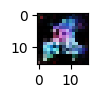

In [48]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 1 noise vector

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

# Resize the generated image
resize_transform = transforms.Resize((16, 16))
resized_fake_images = resize_transform(fake_images)

# Convert to numpy array for visualization
image_noise = resized_fake_images.detach().numpy().reshape((3, 16, 16)) * 0.5 + 0.5

# Display the image
plt.figure(figsize=(1, 0.66))
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()


<strong> Plotting losses </strong>

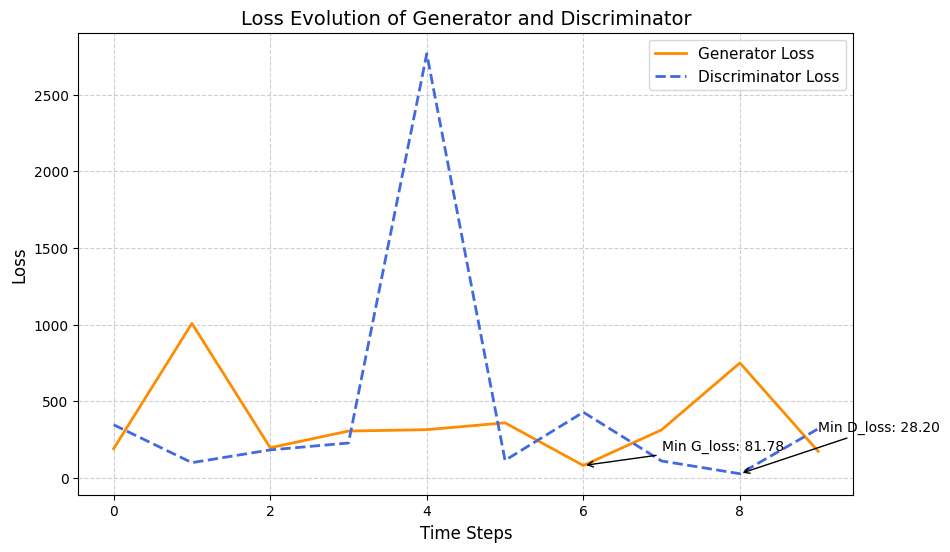

In [49]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()


<strong> Plotting FID (Fréchet Inception Distance) values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

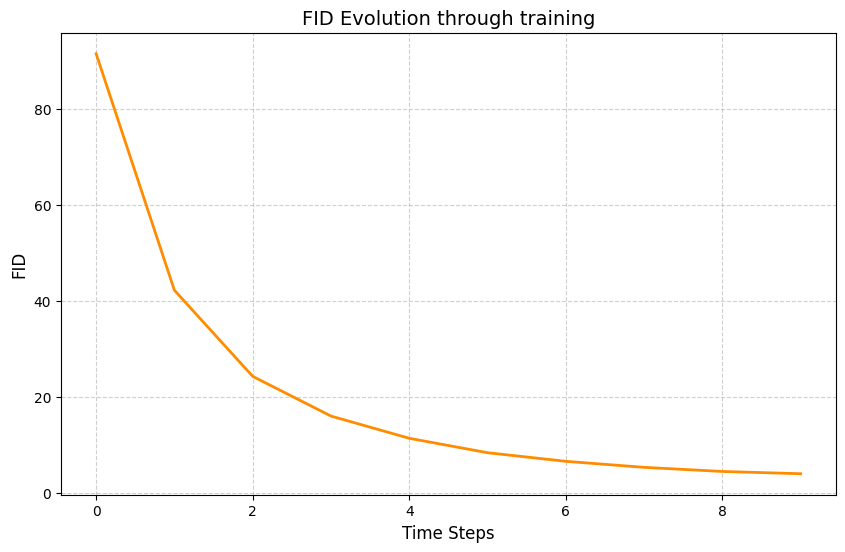

In [50]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)

In [70]:
torch.save(D_unet.state_dict(), "models/d_unet.pth")
torch.save(G_unet.state_dict(), "models/g_unet.pth")

In [72]:
G_unet_saved = Unet_Generator_V2(latent_dim, channels_out)
G_unet_saved.load_state_dict(torch.load("models/g_unet.pth"))

<All keys matched successfully>

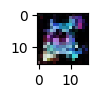

In [73]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 1 noise vector

# Generate images
fake_images = G_unet_saved(noise)

# Resize the generated image
resize_transform = transforms.Resize((16, 16))
resized_fake_images = resize_transform(fake_images)

# Convert to numpy array for visualization
image_noise = resized_fake_images.detach().numpy().reshape((3, 16, 16)) * 0.5 + 0.5

# Display the image
plt.figure(figsize=(1, 0.66))
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()